In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date
from bs4 import BeautifulSoup
import requests


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [2]:
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_only/April_1_unmerged_fires_with_FWI.csv"
fire3 = fv.prep_fire_files(path)


In [3]:
# ### Here I attempt to subset the fires to just the ones that are not affected by a merge-based jump in area. They are fires that either were never merged into anoutehr fire OR fires before they were merged into anouther fire


# def remerge_largefire(fires):
#     '''
#     If two final feds perimeters intersect spatialy, check if one ended before the other began. If yes, give it the ID of the earlier perimeter. 
#     Note: Could optionally be spitting out time differences, or sorting by them. For Quebec, was a max of 22 days, min of 1 day. Theoretically, not sure why the 1 day perimeter wasn't merged by feds. 
#     '''
#     # Get an id, first/ last t per ID, and a geometry
#     first_perims = fires[~fires.geometry.isnull()].groupby("fireID").t.min().reset_index()
#     last_perims = fires[~fires.geometry.isnull()].groupby("fireID").t.max().reset_index()
#     plot_last = fires.merge(last_perims, on = ["fireID", "t"], how = 'right')
#     plot_first = fires.merge(first_perims, on = ["fireID", "t"], how = 'right')
#     plot_last = plot_last[["fireID", "t", "geometry"]]
#     plot_first = plot_first[["fireID", "t", "geometry"]]
                    
#     # Check what perimeters spatially intersect into anouther one through time
#     last_in_last = plot_last.sjoin(plot_last, how = "left", predicate = "intersects")
#     lil = last_in_last.groupby(["fireID_left",]).t_right.min().reset_index()
#     id_with_max_time = lil.merge(last_in_last[["t_right", "t_left", "geometry", "fireID_right", "fireID_left"]], on = ["t_right", "fireID_left"], how = "right")

#     id_with_max_time = id_with_max_time.rename(columns={"fireID_right": "mergeID", 
#                                      "fireID_left" :"fireID",
#                                      "t_right":"mergeID_t",
#                                      "t_left":"fireID_end_t"
#     })

#     id_with_max_time_check = id_with_max_time[id_with_max_time.fireID_end_t < id_with_max_time.mergeID_t]

#     ### FireID the earlier perimeter that later perimeters are merged into. "mergeID" describes the merge-ey
#     fireID_with_merge = id_with_max_time_check.groupby(["fireID"]).mergeID.unique().reset_index() 
#     #print(fireID_with_merge)

#     mergeID_with_fireID  = id_with_max_time_check.groupby(["mergeID"]).fireID.unique().reset_index()
#     #print(mergeID_with_fireID)
                    
#     # Check when the fireID and mergeID started/stopped. 
#     get_merge_start = plot_first[["fireID", "t"]].rename(columns={"fireID":"mergeID", 
#                                                            "t":"mergeID_start_t"})
#     #print(get_merge_start)
#     get_fireID_start =  plot_first[["fireID", "t"]].rename(columns={ "t":"fireID_start_t"})
#     #print(get_fireID_start)

#     id_map = id_with_max_time_check.merge(get_merge_start, on = ["mergeID"])
#     id_map = id_map.merge(get_fireID_start, on = ["fireID"])
#     id_map = id_map[["fireID","fireID_start_t",  "fireID_end_t", "mergeID", "mergeID_start_t", "mergeID_t"]]
#     id_map["time_diff_fireIDend_mergeIDstart"] = id_map.fireID_end_t.astype('datetime64[ns]') - id_map.mergeID_start_t.astype('datetime64[ns]') ## Negative means that mergeID started after fireID ended
#     #print(id_map)
#     # Below code is just for isolateing perimeters that ended before the later perimetetr began. This is useful for identifying places where the assumptino to invalidate a fire after five days might be wrong. 
# #     # Subset to IDs where one fire "ended" before the next fire began                
# #     only_IDs_with_negative_dates = id_map[id_map.time_diff_fireIDend_mergeIDstart.dt.days < 0]
    
# #     # Go through an reindex just the IDs that overlap in space but not time                
# #     fires["old_id"] = ""
# #     fire_ids = only_IDs_with_negative_dates.mergeID.unique() ## Gives the IDs of fires to be merged into anouther fire

# #     for i in fire_ids:
# #         print("start: ")
# #         print(fire_ids)
# #         min_t = id_with_max_time_check[id_with_max_time_check.mergeID == i].fireID_end_t.min()
# #         print(min_t)
# #         sm_id_map = id_with_max_time_check[(id_with_max_time_check.mergeID == i) & (id_with_max_time_check.fireID_end_t == min_t)]
# #         print(sm_id_map.fireID.values)
# #         if(len(sm_id_map) == 0):
# #             print("ID", i, " only merges with self")
# #             fires["old_id"][fires.fireID == i] = i
# #         else:
# #             if(len(sm_id_map) != 1):
# #                 print("There are two perimeters that intersect with ID",i, " that started at the same time.")
# #                 print(sm_id_map)
# #                 break

# #             fires["old_id"][fires.fireID == i] = i
# #             fires["fireID"][fires.fireID == i] = str(*sm_id_map.fireID.values)
                    
# #     #return(fires)
#     return(id_map)

In [4]:
def get_nccs_url(pattern, url = 'https://portal.nccs.nasa.gov/datashare/GlobalFWI/ForecastFWIEXPERIMENTAL/QuebecAllFires.Radius.25.km.401.biggestFires/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/', ext = 'csv'):    

#url = 'https://portal.nccs.nasa.gov/datashare/GlobalFWI/ForecastFWIEXPERIMENTAL/QuebecAllFires.Radius.25.km.216.biggestFires/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/'
#ext = 'csv'
    pattern = pattern + "_Lat"
    file_list = []
    for file in listFD(url, ext):
        file_list.append(file)

    try_pd = pd.DataFrame(file_list, columns= ["urls"])
    size = try_pd[try_pd.urls.str.contains(pattern)].urls.values.size
    if(size == 0):
        print("No matches found to pattern. Returning None.")
        return(None)
    if(size >= 2):
        print("Multiple matches found:")
        print(try_pd[try_pd.urls.str.contains(pattern)].urls.values)
        raise ValueError()
    url = try_pd[try_pd.urls.str.contains(pattern)].urls.values[0]
    return(url)

def get_gridded_fwi(fireID):
    
    # Get the URL for the file
    fireID = str(fireID)
    pattern = "FWI." + fireID
    url = get_nccs_url(pattern = pattern)
    
    if(url is not None):
        
        # Get the DF
        grid_FWI = pd.read_csv(url)
        # Change names
        grid_FWI = grid_FWI.rename(columns={'INITDATE': 't', 
                                 "0":"FWI",
                                 "1":"FWI_lead_1",
                                 "2":"FWI_lead_2",
                                 "3":"FWI_lead_3",
                                 "4":"FWI_lead_4",
                                 "5":"FWI_lead_5",
                                 "6":"FWI_lead_6",
                                 "7":"FWI_lead_7",
                                 "8":"FWI_lead_8"
                                })
        # Change dates
        grid_FWI.t = grid_FWI.t.astype("datetime64[ns]").dt.strftime('%Y-%m-%d 12:00:00')

        # return
        return(grid_FWI)
    else:
        return(None)

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

In [5]:
#fire3 = fire3[~fire3.fireID.str.contains("_")]



In [6]:
fire3 = fire3.sort_values(by = ["fireID", "t"])
fire3 = fire3[~fire3.FWI.isna()]
fire3.farea = fire3.farea.astype("int64")
fire3["farea_diff"] = fire3.groupby("fireID").farea.diff()
fire3["farea_diff_minus1"] = fire3.groupby("fireID").farea.diff(-1)

fire3["farea_shifted"] = fire3.groupby("fireID").farea.shift(periods = 1)
#fire3["farea_shifted_-1"] = fire3.groupby("fireID").farea.shift(periods = -1) ## not super useful
fire3["FWI_diff"] =  fire3.groupby("fireID").FWI.diff()
fire3["FWI_shifted"] = fire3.groupby("fireID").FWI.shift(periods = 1)

In [7]:
#fire3.groupby("fireID").FWI.diff().unique()
fire3.groupby("fireID").FWI.diff()

0             NaN
34       1.837159
11      -7.341959
9       -0.095746
35       0.000418
           ...   
10187    0.451475
10185    0.108069
10182    1.116047
10197    2.341458
10198    5.332858
Name: FWI, Length: 5118, dtype: float64

5118
370


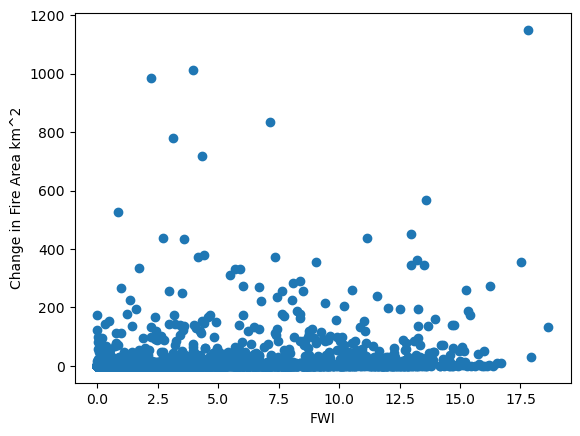

In [8]:
plt.scatter(fire3.FWI, fire3.farea_diff)
plt.ylabel("Change in Fire Area km^2")
plt.xlabel("FWI")

print(len(fire3.farea_diff))
print(len(fire3.fireID.unique()))

Text(0.5, 0, 'FWI')

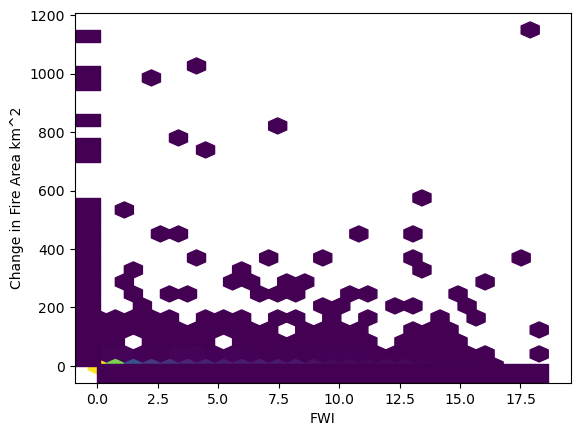

In [9]:
plt.hexbin(fire3.FWI, fire3.farea_diff, marginals = True, mincnt = 1, gridsize = 25)
plt.ylabel("Change in Fire Area km^2")
plt.xlabel("FWI")

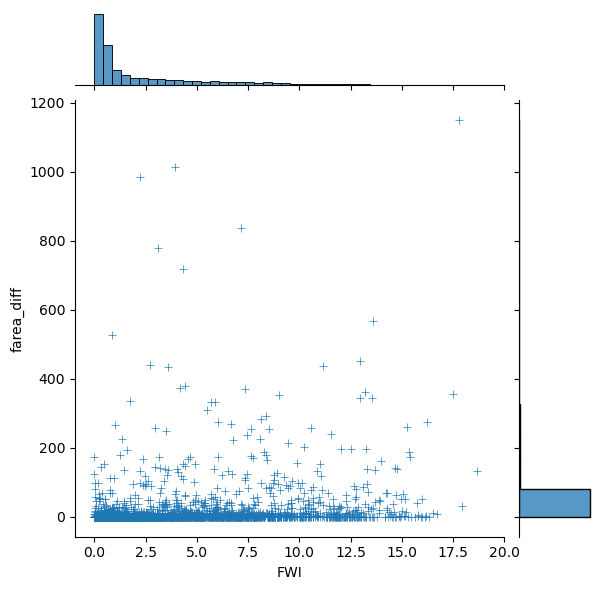

In [10]:
import seaborn as sns 
fire3 = fire3[~fire3.index.duplicated()]

x_var = "FWI"
y_var = "farea_diff"
sns.jointplot(data=fire3, x= fire3.FWI, y= fire3.farea_diff, marker="+") 
#plt.plot(range(0,28), range(0,28), color = "black")
plt.xlabel(x_var)
plt.ylabel(y_var)

## Stats



plt.show()

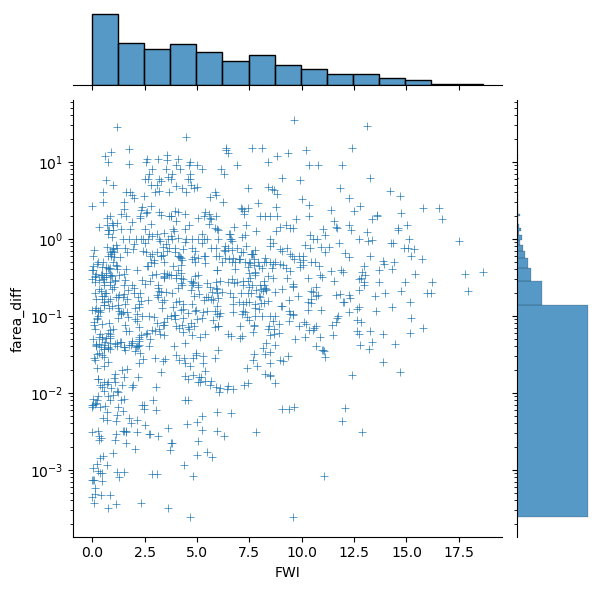

In [11]:
import seaborn as sns 
fire3 = fire3[~fire3.index.duplicated()]

x_var = "FWI"
y_var = "farea_diff"
row_mask = (fire3.farea_diff > 0.01)
sns.jointplot(data=fire3[row_mask], x= x_var, y= fire3[row_mask].farea_diff/fire3[row_mask].farea_shifted, marker="+") 
#plt.plot(range(0,28), range(0,28), color = "black")
plt.yscale("log") 
plt.xlabel(x_var)
plt.ylabel(y_var)

## Stats



plt.show()

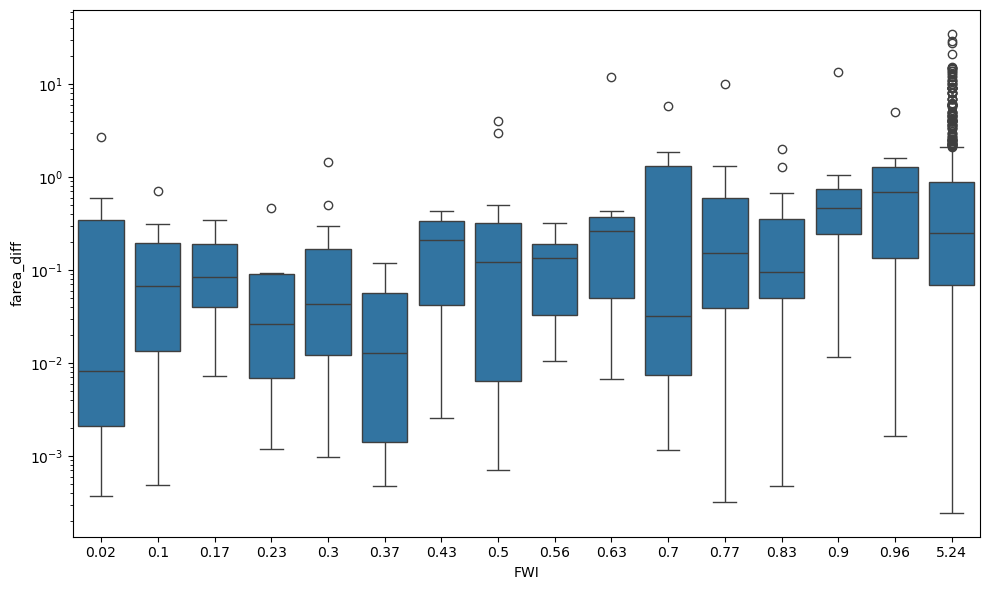

In [12]:
# Define the number of bins and bin edges
num_bins = 15
bin_edges = np.linspace(0, 1, num_bins + 1)

# Bin the x values
bin_indices = np.digitize(fire3[x_var], bin_edges)

# Create a DataFrame with x, y, and bin information
fire3["bin"] = bin_indices

# Create violin plots for each bin
plt.figure(figsize=(10, 6))
sns.boxplot(data=fire3[row_mask], x='bin', y=fire3[row_mask].farea_diff/ fire3[row_mask].farea_shifted)
plt.yscale("log") 
# Add labels and title
plt.xlabel(x_var)
plt.ylabel(y_var)


# Customize the plot
plt.grid(False)
plt.xticks(np.arange(num_bins + 1), [f'{round(fire3[fire3.bin == i][x_var].mean(), 2)}' for i in set(bin_indices)])

# Show plot
plt.tight_layout()
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'FWI')

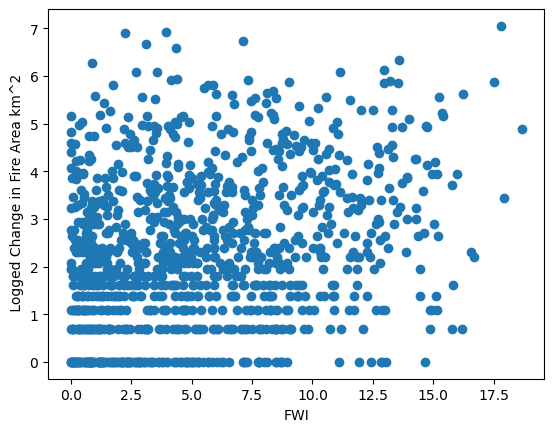

In [13]:
plt.scatter(fire3.FWI, np.log(fire3.farea_diff))
plt.ylabel(" Logged Change in Fire Area km^2")
plt.xlabel("FWI")

Text(0.5, 0, 'FWI')

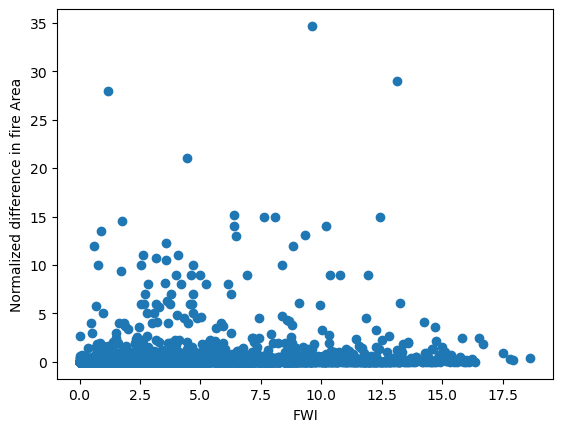

In [14]:
# plt.scatter(fire3.FWI_diff, fire3.farea_diff/fire3.farea_shifted, c = fire3.lat_centroid)
# plt.ylabel("Change in Fire Area km^2")
# plt.xlabel("FWI")

#plt.scatter(fire3[~fire3.fireID.str.contains("_")].FWI, fire3[~fire3.fireID.str.contains("_")].farea_diff/fire3[~fire3.fireID.str.contains("_")].farea_shifted)
plt.scatter(fire3.FWI, fire3.farea_diff/fire3.farea_shifted)
plt.ylabel("Normalized difference in fire Area")
plt.xlabel("FWI")

Text(0.5, 0, 'FWI diff')

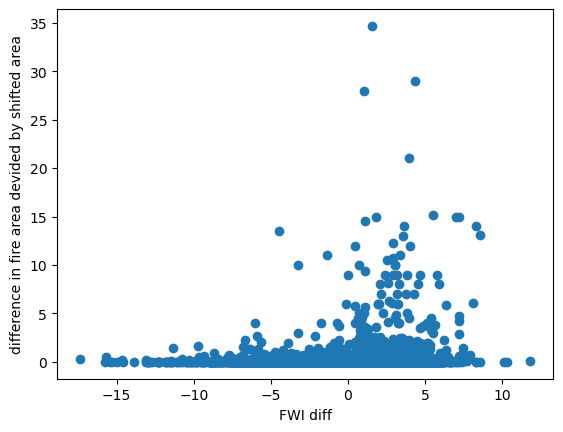

In [15]:
plt.scatter(fire3.FWI_diff, fire3.farea_diff/fire3.farea_shifted)
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI diff")

In [16]:
# plt.scatter(fire3.FWI_diff, np.log(fire3.farea_diff)/np.log(fire3.farea_shifted))
# plt.ylabel("difference in fire area devided by shifted area")
# plt.xlabel("FWI")

Text(0.5, 0, 'FWI')

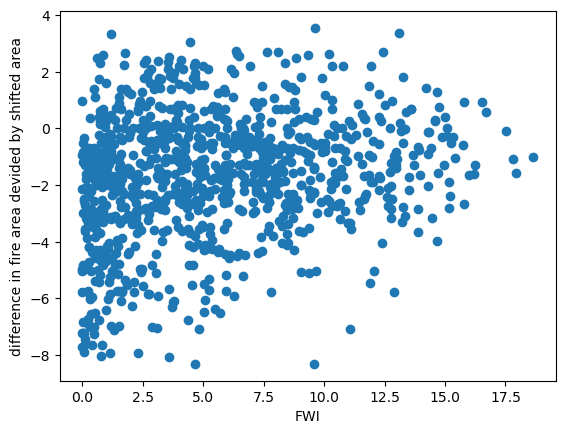

In [17]:
plt.scatter(fire3.FWI, np.log(fire3.farea_diff/fire3.farea_shifted))
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI")

Text(0.5, 0, 'FWI_diff')

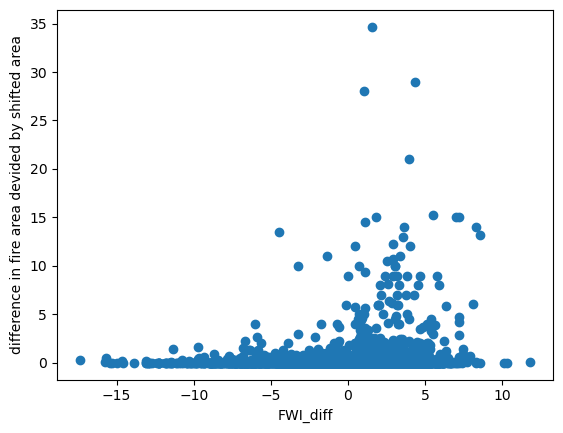

In [18]:
plt.scatter(fire3.FWI_diff, fire3.farea_diff/fire3.farea_shifted) ## Some potential?? Need to return with updated FWI values. 
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI_diff")

Text(0.5, 0, 'FWI_diff')

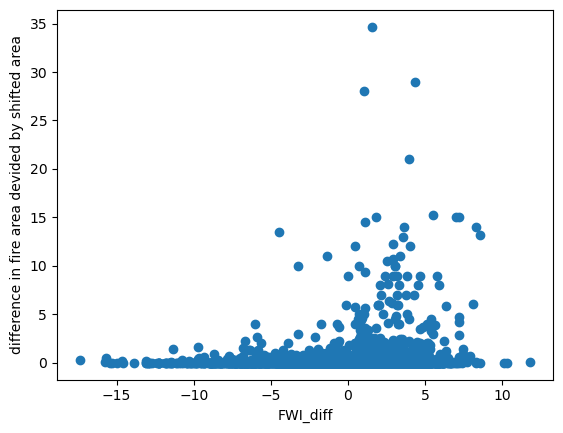

In [19]:
plt.scatter(fire3.FWI_diff, (fire3.farea_diff/fire3.farea_shifted)) ## Some potential?? Need to return with updated FWI values. 
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI_diff")

Text(0.5, 0, 'FWI_diff')

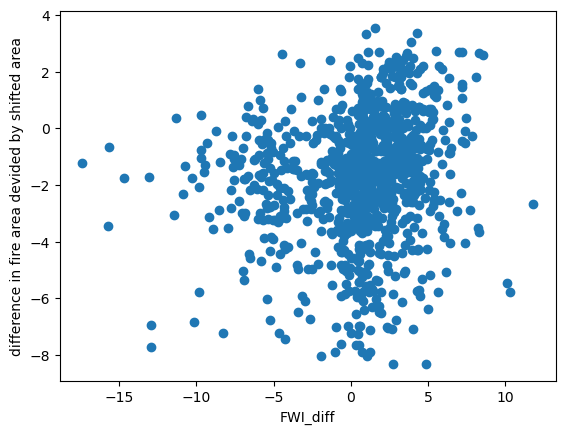

In [20]:
plt.scatter(fire3.FWI_diff, np.log(fire3.farea_diff/fire3.farea_shifted))
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI_diff")

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'FWI_diff')

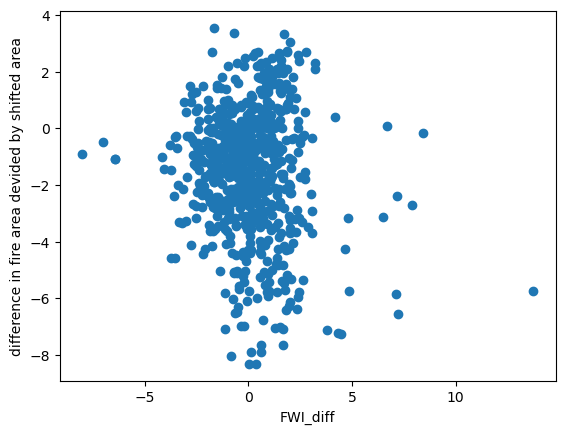

In [21]:
plt.scatter(np.log(fire3.FWI_diff/fire3.FWI_shifted), np.log(fire3.farea_diff/fire3.farea_shifted))
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI_diff")

In [22]:
### make a normalized FWI

def normalize_fwi(df, col = "FWI"):
    #print(df[col].mean())
    df[col+"_norm"] = df[col]/df[col].mean()
    return(df)

def normalize_fwi_diff(df, col = "FWI"):
    #print(df[col].mean())
    df["FWI_diff"+"_norm"] = df["FWI_diff"]/df[col].mean()
    return(df)


# def normalize_fwi(df, col = "FWI"):
#     fid = str(*df.fireID.unique())
#     #print(fid)
#     gridded = get_gridded_fwi(fid)
#     gridded.t = gridded.t.astype("datetime64[ns]")
#     df[col+"_norm"] = df[col]/gridded[col].mean()
#     return(df)

In [23]:
fire3 = fire3.groupby("fireID").apply(normalize_fwi).reset_index(drop = True)

fire3 = fire3.groupby("fireID").apply(normalize_fwi_diff).reset_index(drop = True)

In [24]:
#fire3

Text(0.5, 0, 'Normalized FWI')

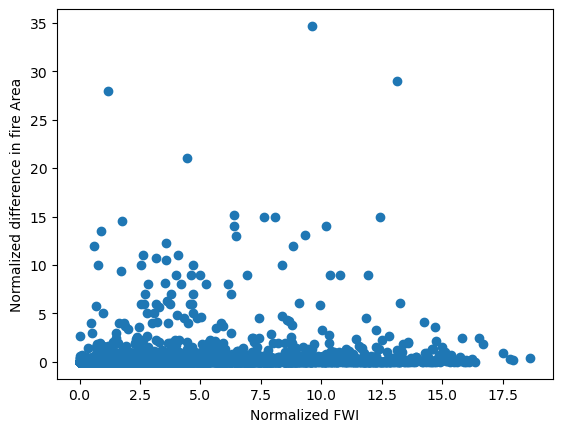

In [25]:
plt.scatter(fire3.FWI, fire3.farea_diff/fire3.farea_shifted)
plt.ylabel("Normalized difference in fire Area")
plt.xlabel("Normalized FWI")

In [26]:
row_mask = (~fire3.fireID.str.contains("_"))


# plt.scatter(fire3[row_mask].FWI_norm, fire3[row_mask].farea_diff/fire3[row_mask].farea_shifted,  c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.5)
# plt.ylabel("Normalized difference in fire Area")
# plt.xlabel("Normalized FWI")

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Normalized FWI')

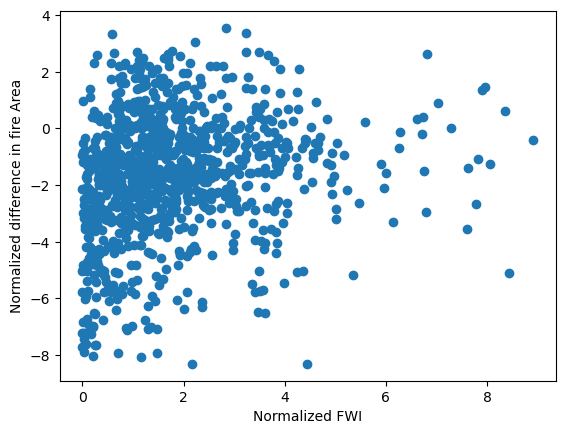

In [27]:
plt.scatter(fire3.FWI_norm, np.log(fire3.farea_diff/fire3.farea_shifted))
plt.ylabel("Normalized difference in fire Area")
plt.xlabel("Normalized FWI")

Text(0.5, 0, 'Normalized FWI')

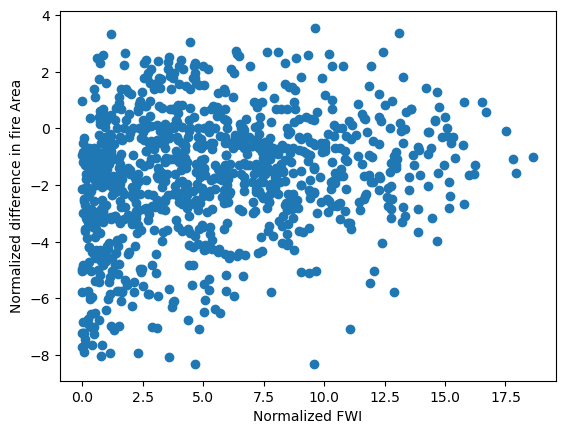

In [28]:
plt.scatter(fire3.FWI, np.log(fire3.farea_diff/fire3.farea_shifted))
plt.ylabel("Normalized difference in fire Area")
plt.xlabel("Normalized FWI")

Text(0.5, 0, 'FWI_diff')

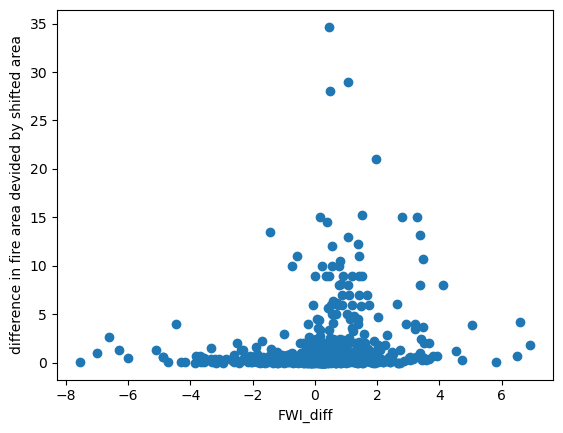

In [29]:
row_mask = (~fire3.fireID.str.contains("_"))  & (fire3.farea_diff > 0.1) & (fire3.farea >= 2) # & (fire3[row_mask].farea_diff/fire3[row_mask].farea_shifted > 1)

plt.scatter(fire3[row_mask].FWI_diff_norm, fire3[row_mask].farea_diff/fire3[row_mask].farea_shifted) ## Some potential?? Need to return with updated FWI values. 
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI_diff")

Text(0.5, 0, 'FWI_diff')

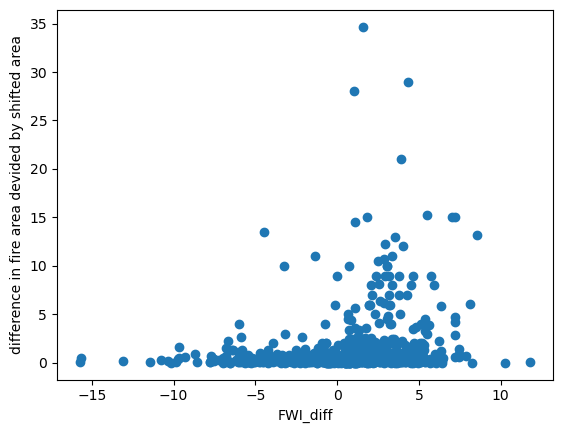

In [30]:
plt.scatter(fire3[row_mask].FWI_diff, fire3[row_mask].farea_diff/fire3[row_mask].farea_shifted) ## Some potential?? Need to return with updated FWI values. 
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI_diff")

Text(0.5, 0, 'FWI')

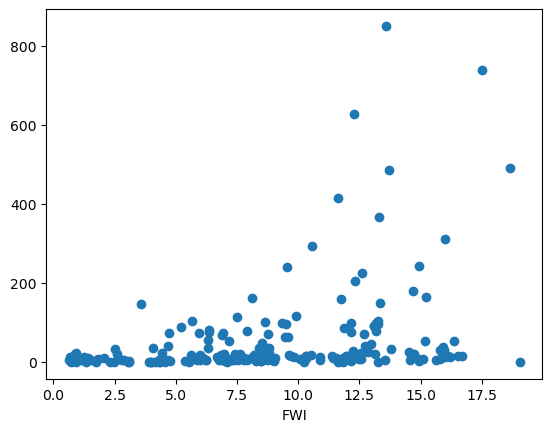

In [31]:
### Look at max area and max FWI

fire3["max_fwi"] = fire3.groupby("fireID").FWI.transform('max')
fire3["max_farea_diff"] = fire3.groupby("fireID").farea_diff.transform('max')


row_mask = (fire3.FWI == fire3["max_fwi"]) &  (~fire3.fireID.str.contains("_"))

plt.scatter(fire3[row_mask].FWI, fire3[row_mask].farea) ## Some potential?? Need to return with updated FWI values. 
#plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI")



Text(0.5, 0, 'FWI')

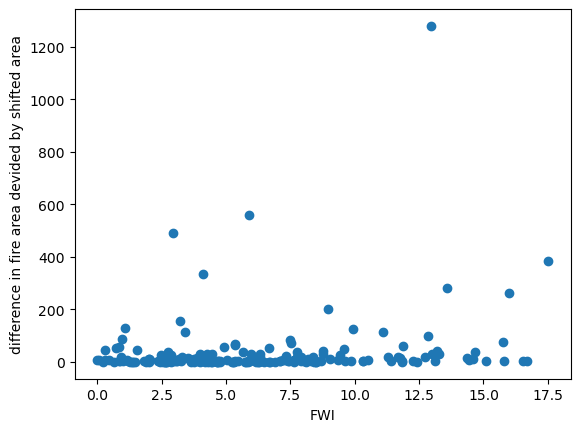

In [32]:
fire3["max_fwi"] = fire3.groupby("fireID").FWI.transform('max')
fire3["max_farea_diff"] = fire3.groupby("fireID").farea_diff.transform('max')


row_mask = (fire3.farea_diff == fire3["max_farea_diff"]) &  (~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

plt.scatter(fire3[row_mask].FWI, fire3[row_mask].farea_shifted) #c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.5) ## Some potential?? Need to return with updated FWI values. 
plt.ylabel("difference in fire area devided by shifted area")
plt.xlabel("FWI")

In [33]:
fire3.groupby("fireID").FWI.max().reset_index()

fireID        FWI
0                                10013  16.120724
1                                10054  10.322991
2                           10054_8244   3.368490
3                                10056   9.538065
4                                10069  10.161166
..                                 ...        ...
365                               9837  13.245852
366                               9843   5.979547
367  9843_10797_10806_10809_10946_9844  10.175493
368                          9843_9844  14.756230
369                               9844   9.443717

[370 rows x 2 columns]

In [34]:
fire3["FWI_max"] = fire3.groupby("fireID").FWI.transform('max')

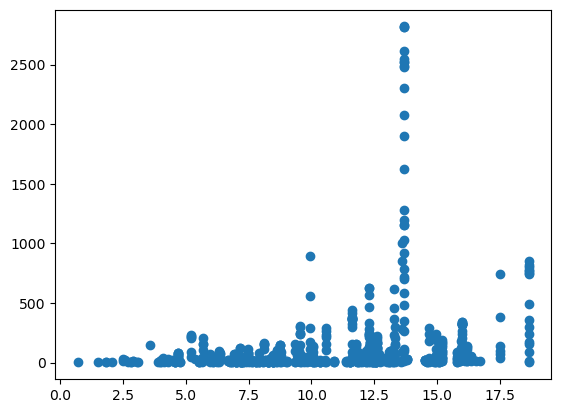

In [35]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

plt.scatter(fire3[row_mask].FWI_max, fire3[row_mask].farea) ## Some potential?? Need to return with updated FWI values. 

Text(0.5, 0, 'Max FWI')

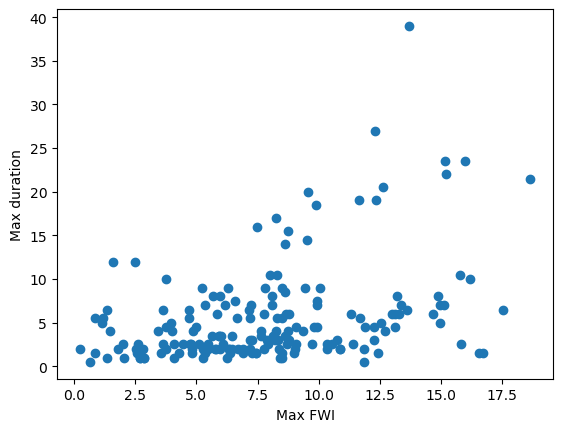

In [36]:
plt.scatter(fire3[row_mask].groupby("fireID").FWI.max(), fire3[row_mask].groupby("fireID").duration.max())
plt.ylabel("Max duration")
plt.xlabel("Max FWI")

Text(0.5, 0, 'FWI')

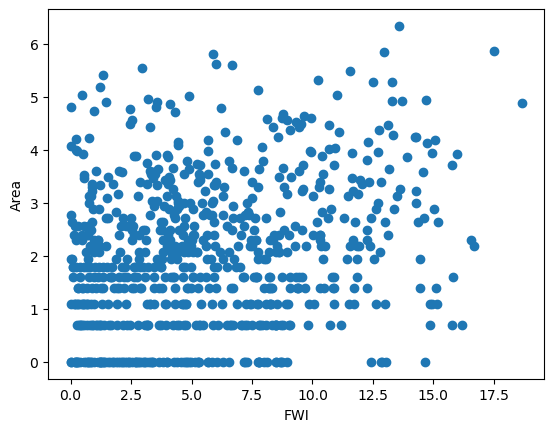

In [37]:
plt.scatter(fire3[row_mask].FWI, np.log(fire3[row_mask].farea_diff)) #c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.5
plt.ylabel("Area")
plt.xlabel("FWI")

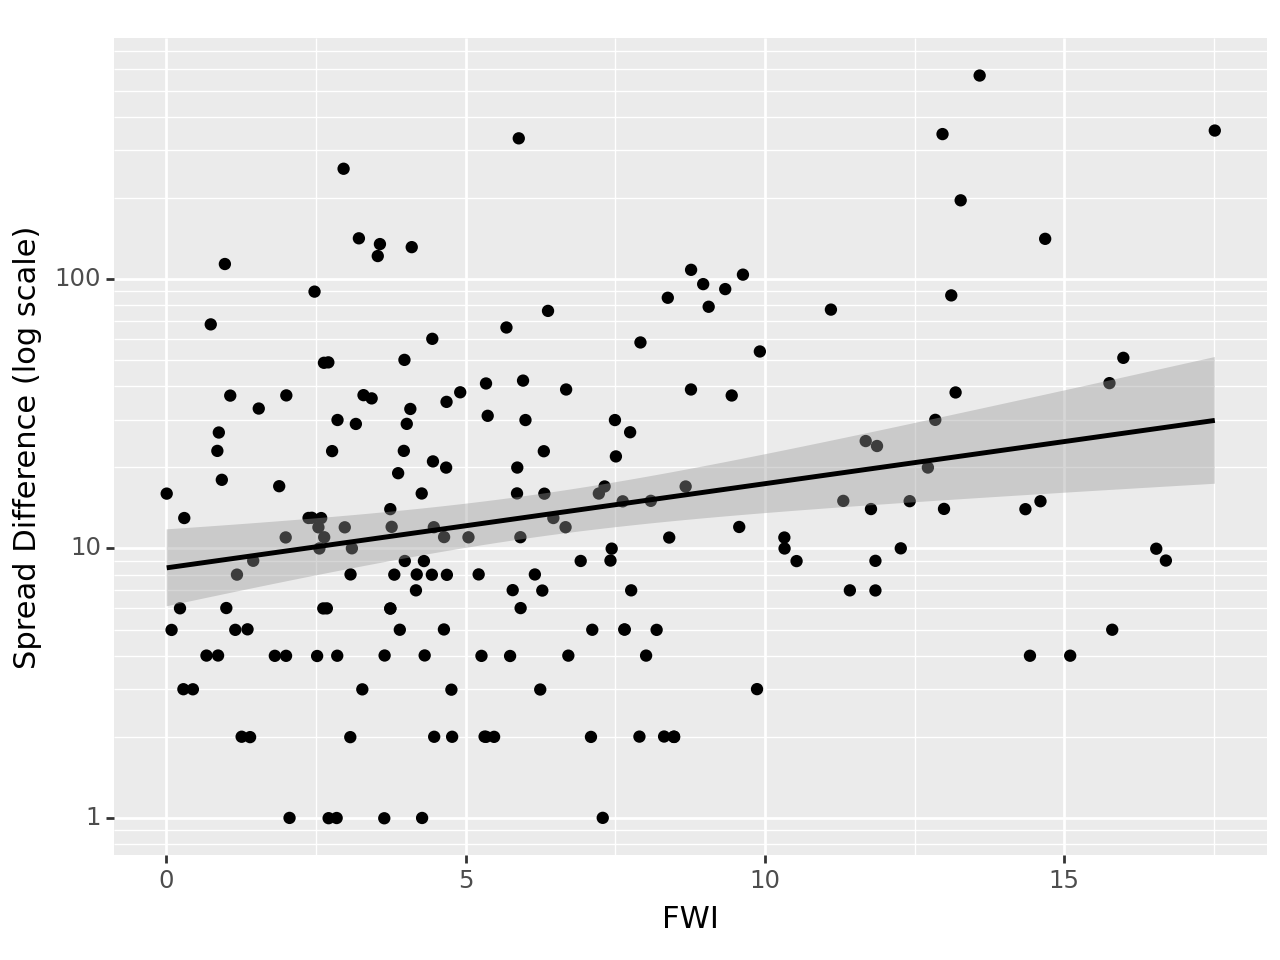

<Figure Size: (640 x 480)>

In [38]:
from plotnine import ggplot, geom_point, geom_jitter, aes, stat_smooth, facet_wrap
import plotnine as plotnine
row_mask = (fire3.farea_diff == fire3["max_farea_diff"]) &  (~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

(ggplot(fire3[row_mask], aes("FWI", fire3[row_mask].farea_diff))
 + geom_jitter()
 + plotnine.labels.ylab("Spread Difference (log scale)")
 + plotnine.labels.xlab("FWI")
 + stat_smooth(method = "glm")
 + plotnine.scale_y_log10()
    
)

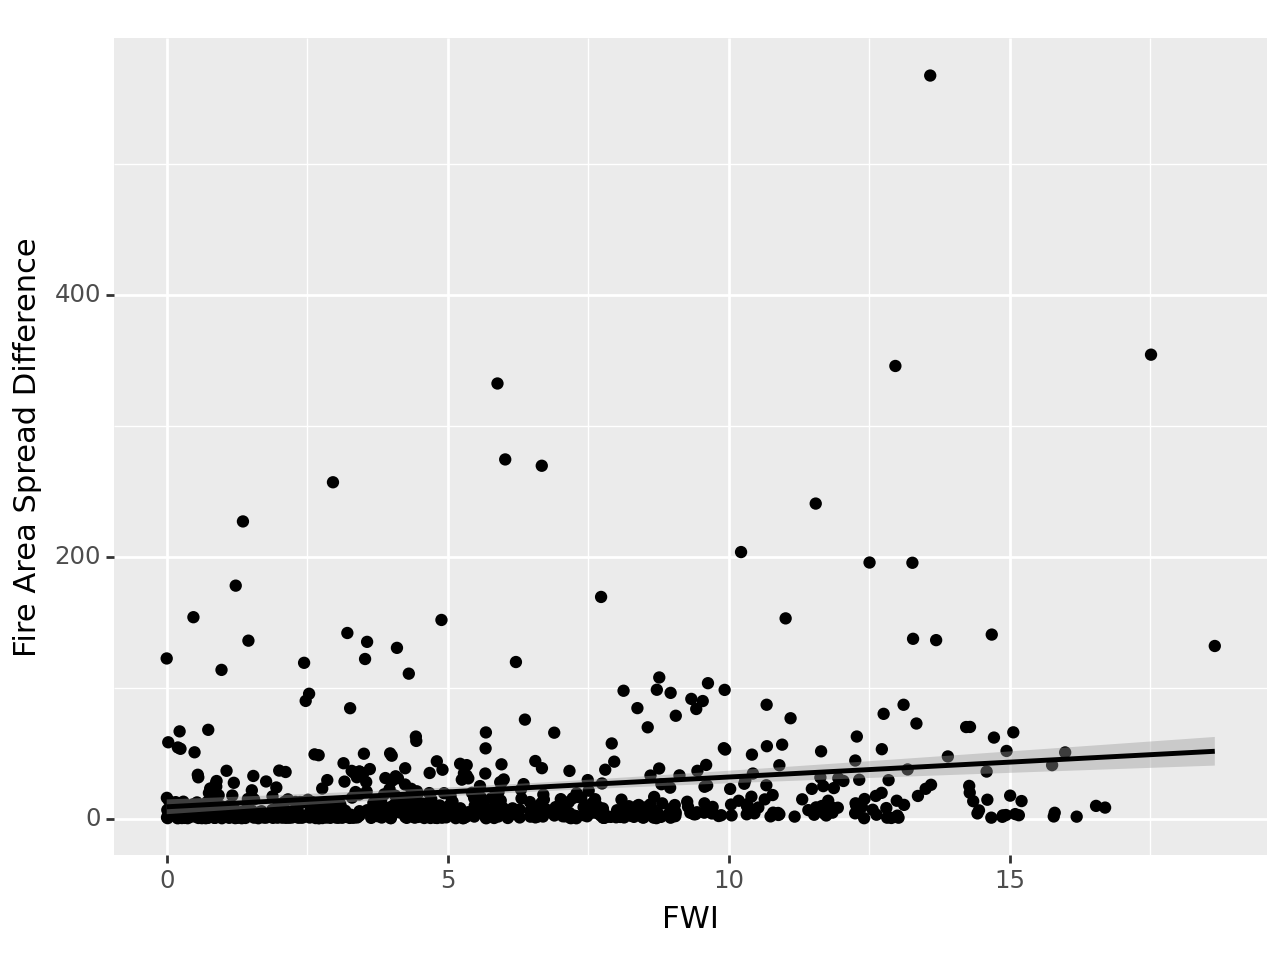

<Figure Size: (640 x 480)>

In [39]:
row_mask =  (~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

(ggplot(fire3[row_mask], aes("FWI", fire3[row_mask].farea_diff))
 + geom_jitter()
 + plotnine.labels.ylab("Fire Area Spread Difference")
 + plotnine.labels.xlab("FWI")
 + stat_smooth(method = "glm")
 #+ plotnine.scale_y_log10()
    
)

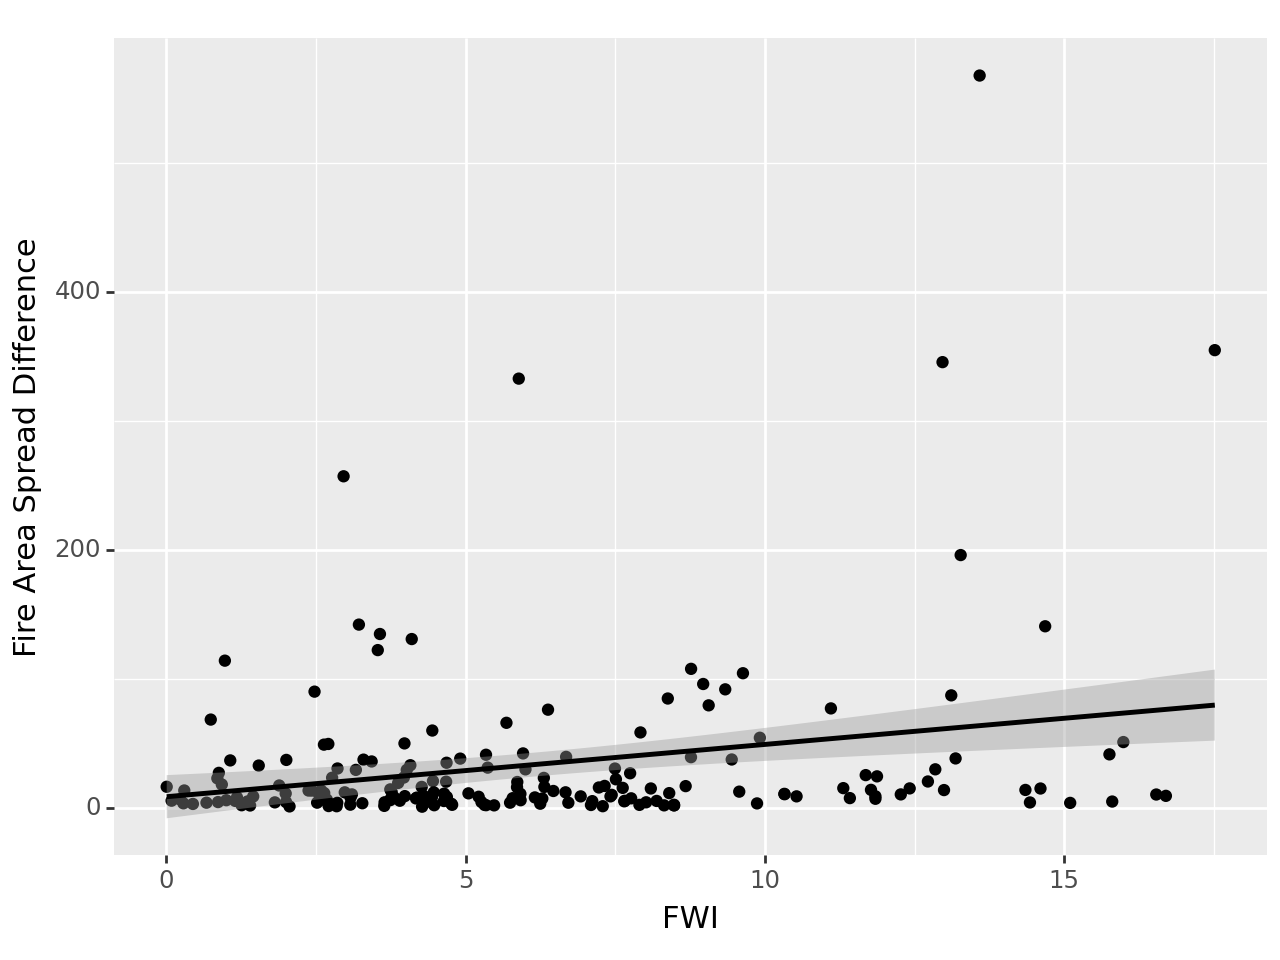

<Figure Size: (640 x 480)>

In [40]:
row_mask = (fire3.farea_diff == fire3["max_farea_diff"]) &  (~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

(ggplot(fire3[row_mask], aes("FWI", fire3[row_mask].farea_diff))
 + geom_jitter()
 + plotnine.labels.ylab("Fire Area Spread Difference")
 + plotnine.labels.xlab("FWI")
 + stat_smooth(method = "glm")
 #+ plotnine.scale_x_log10()
    
)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

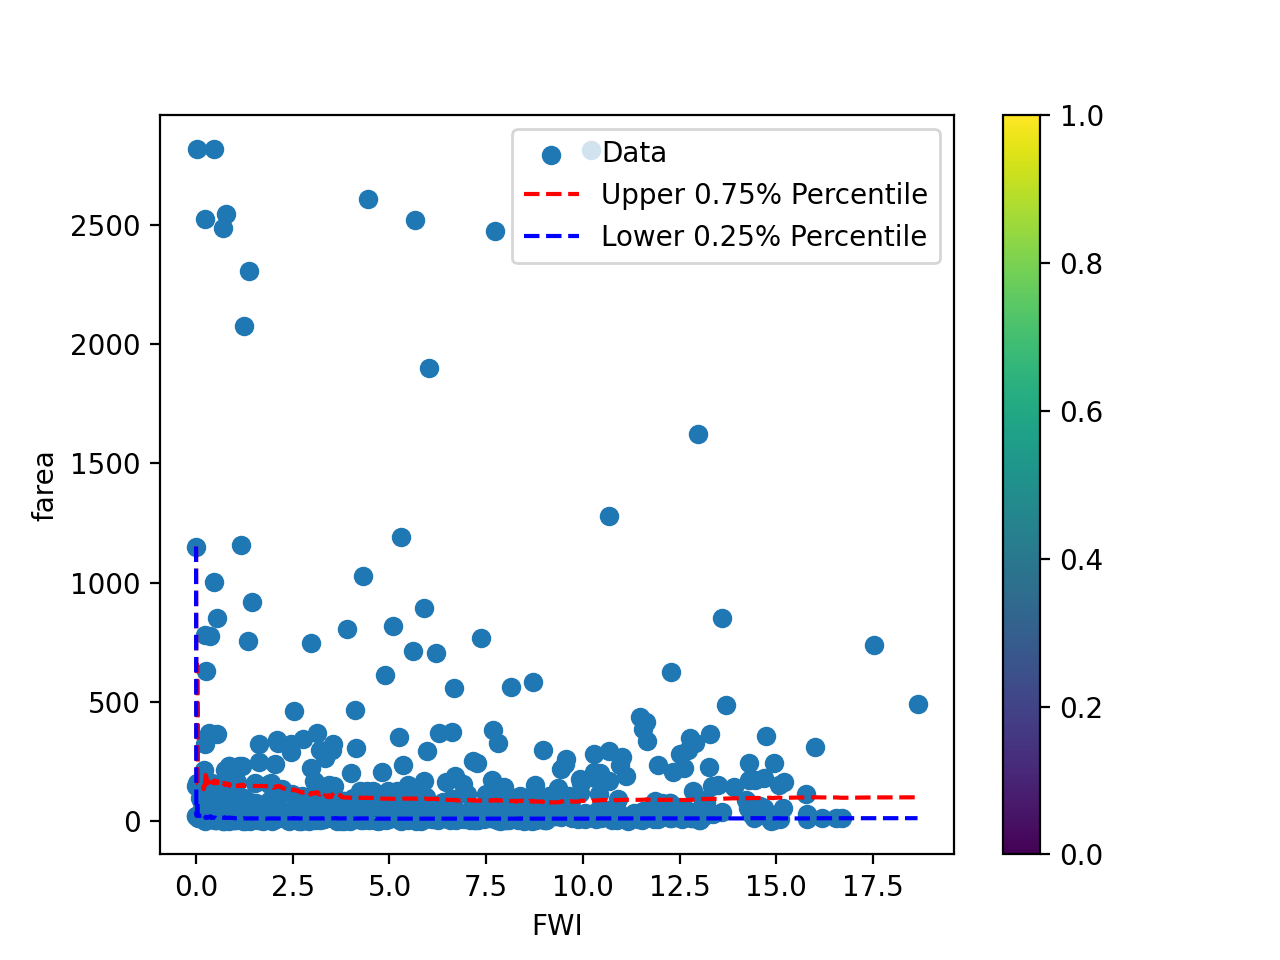

In [41]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "farea"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data') # c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.5

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('')
plt.legend()
#plt.yscale('log')
plt.colorbar()
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

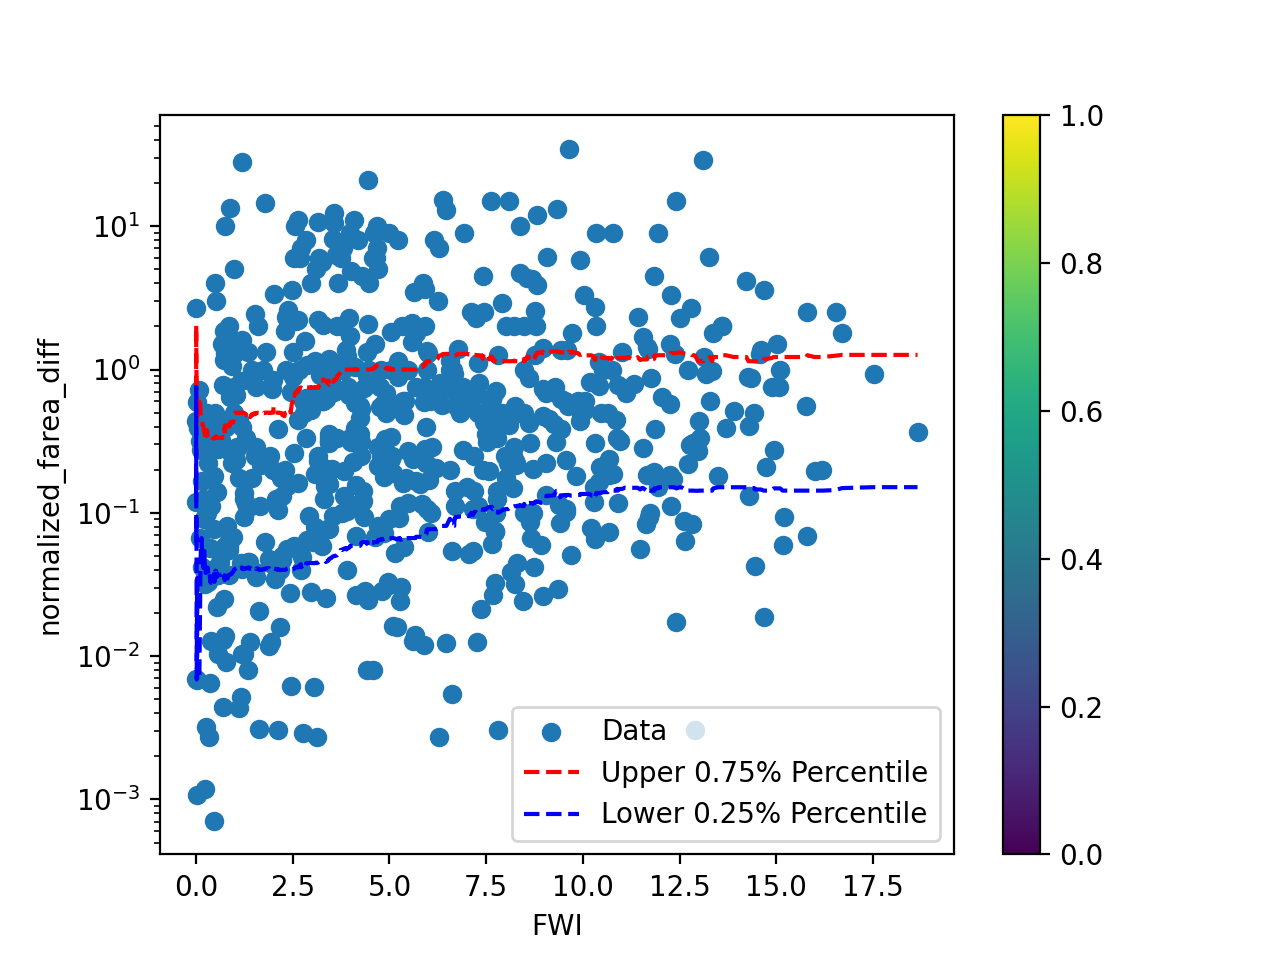

In [42]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "normalized_farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data')#,  c = fire3[row_mask]["day_of_fire"], alpha=0.5 #  norm="log",

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('')
plt.legend()
plt.yscale('log')
plt.colorbar()
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


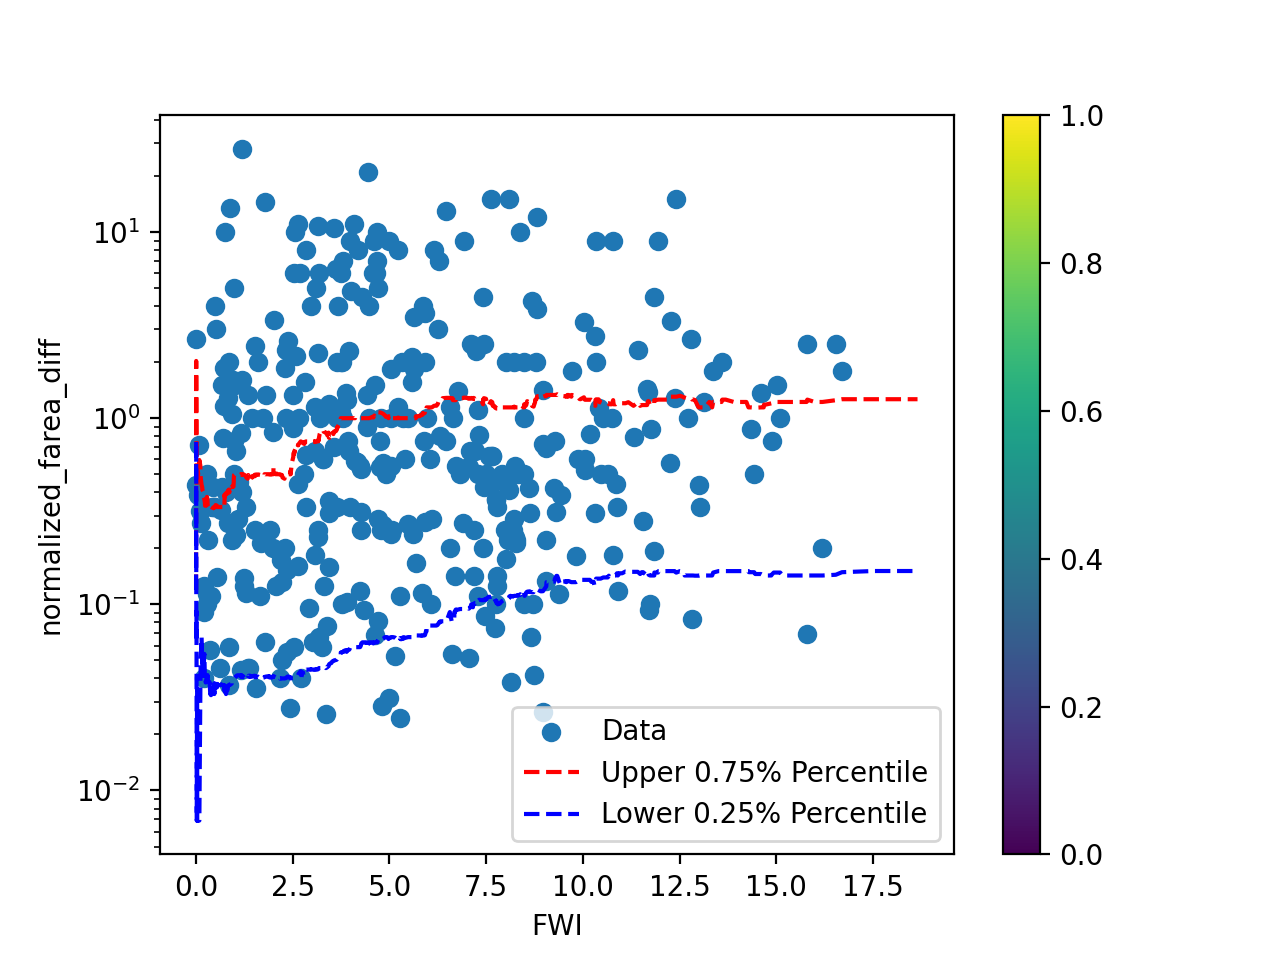

In [43]:
row_mask2 = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) & (fire3.farea < 50) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "normalized_farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask2][x_col], fire3[row_mask2][y_col], label='Data') #,  c = fire3[row_mask2]["day_of_fire"], alpha=0.5 #  norm="log",

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('')
plt.legend()
plt.yscale('log')
plt.colorbar()
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

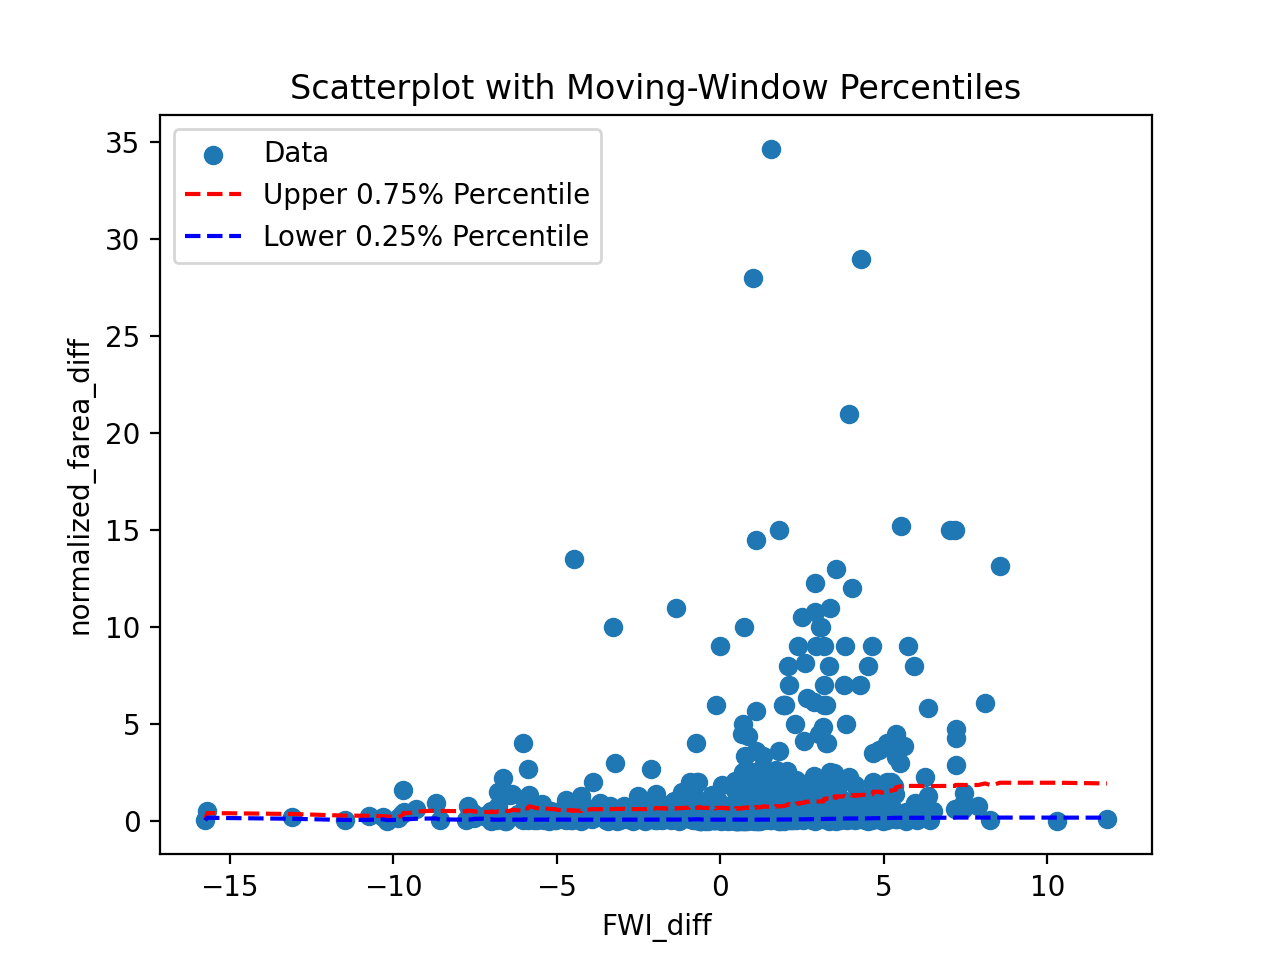

In [44]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI_diff"
y_col = "normalized_farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data')

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Scatterplot with Moving-Window Percentiles')
plt.legend()
#plt.yscale('log')
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

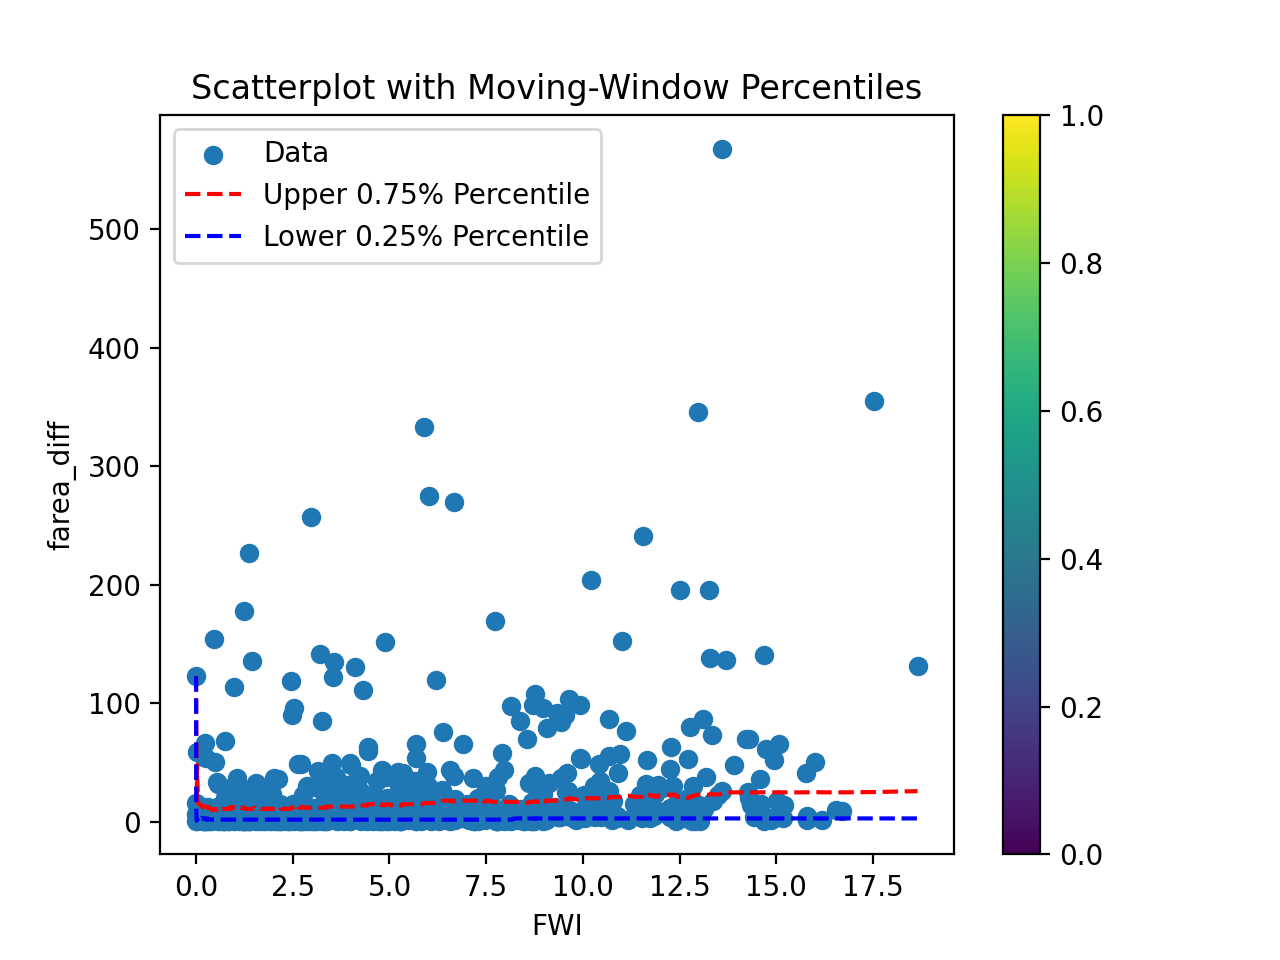

In [45]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data') # c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.5

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Scatterplot with Moving-Window Percentiles')
plt.legend()
#plt.yscale('log')
plt.colorbar()
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

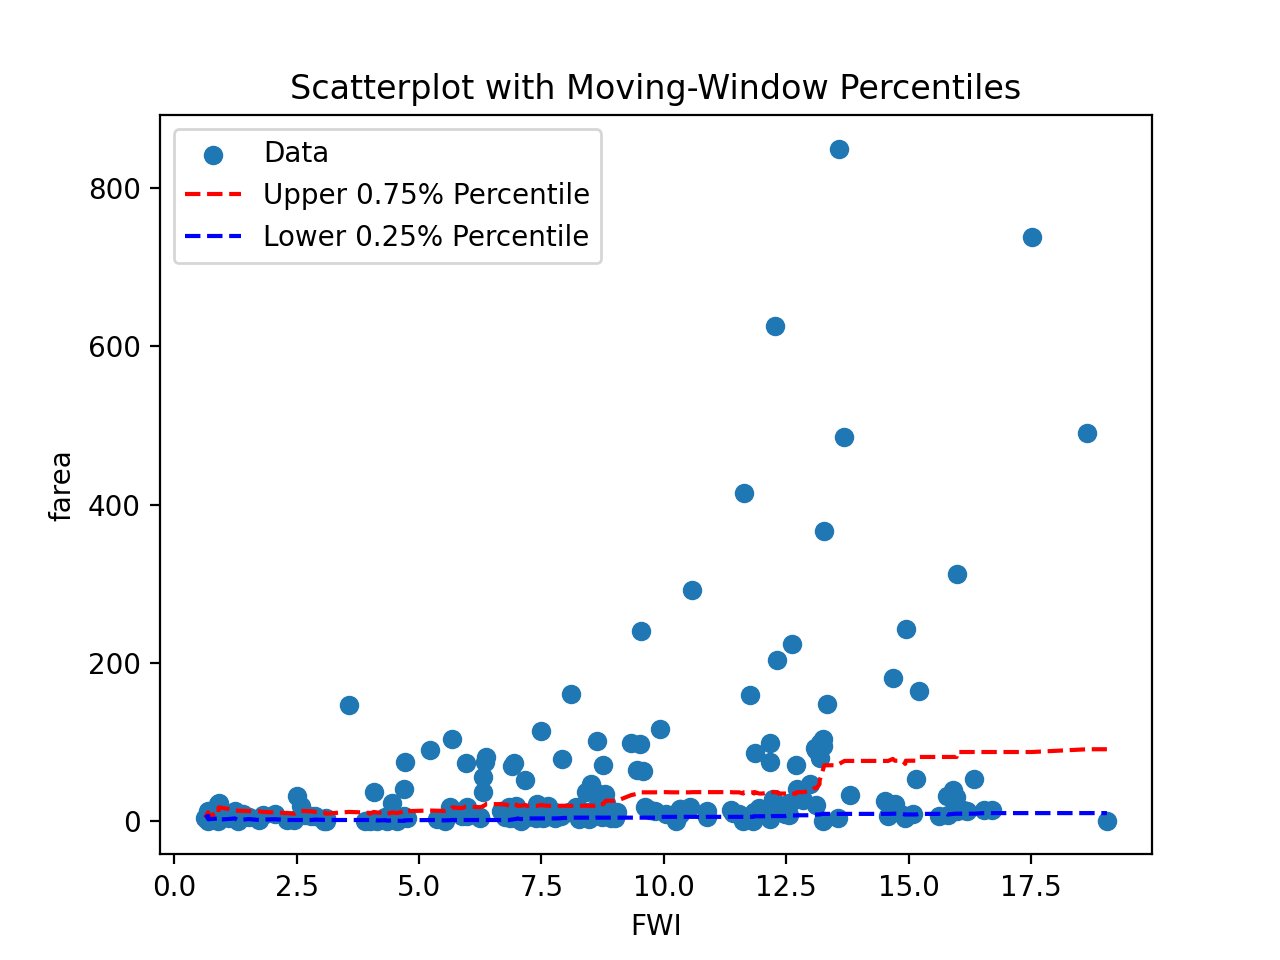

In [46]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.FWI == fire3["max_fwi"])  #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "farea"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(100, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(100, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data')

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Scatterplot with Moving-Window Percentiles')
plt.legend()
#plt.yscale('log')
plt.show()

In [47]:
#np.log(0.1)



In [48]:
### Look at the where the fire is in it's lifetime

def assign_day_of_fire(df):
    df = df.sort_values(by = "t")
    df['day_of_fire'] = df.t.rank()
    return(df)


fire3 = fire3.groupby("fireID").apply(assign_day_of_fire).reset_index(drop = True)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

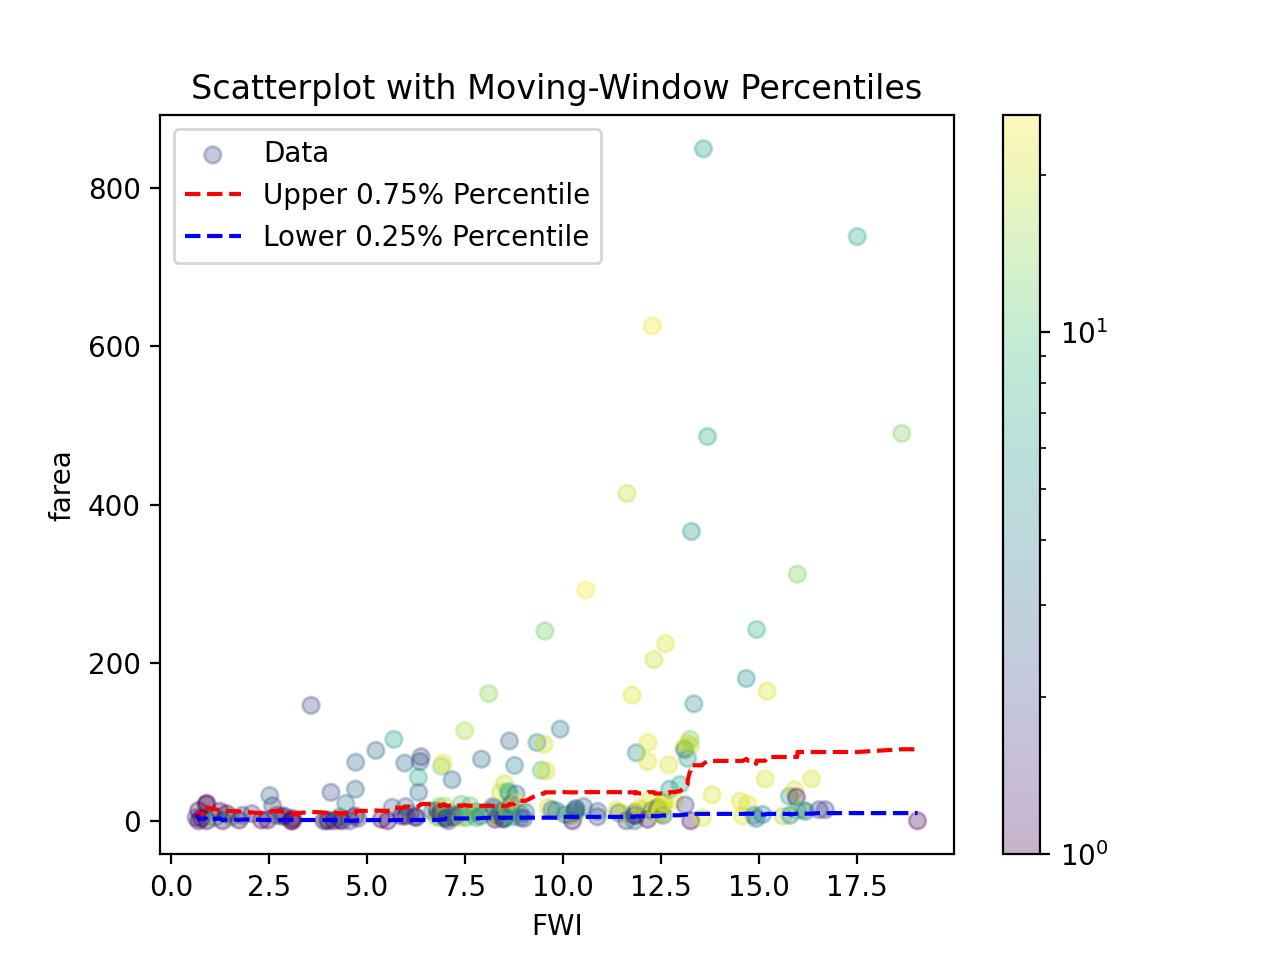

In [49]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.FWI == fire3["max_fwi"])  #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "farea"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(100, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(100, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data',  c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.3)

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Scatterplot with Moving-Window Percentiles')
plt.legend()
plt.colorbar()
#plt.yscale('log')
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

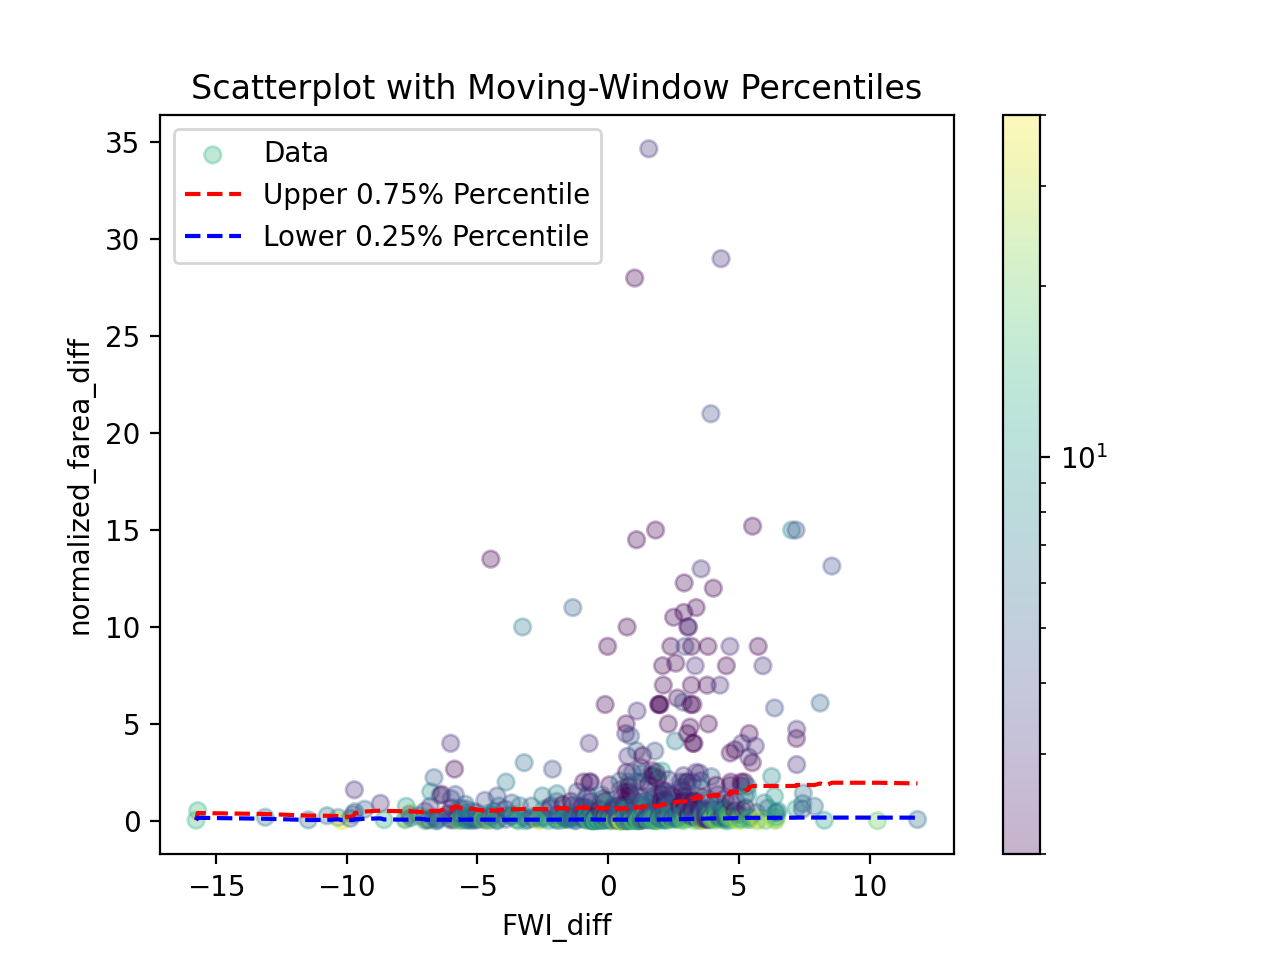

In [50]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI_diff"
y_col = "normalized_farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data', c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.3)

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Scatterplot with Moving-Window Percentiles')
plt.legend()
plt.colorbar()
#plt.yscale('log')
plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

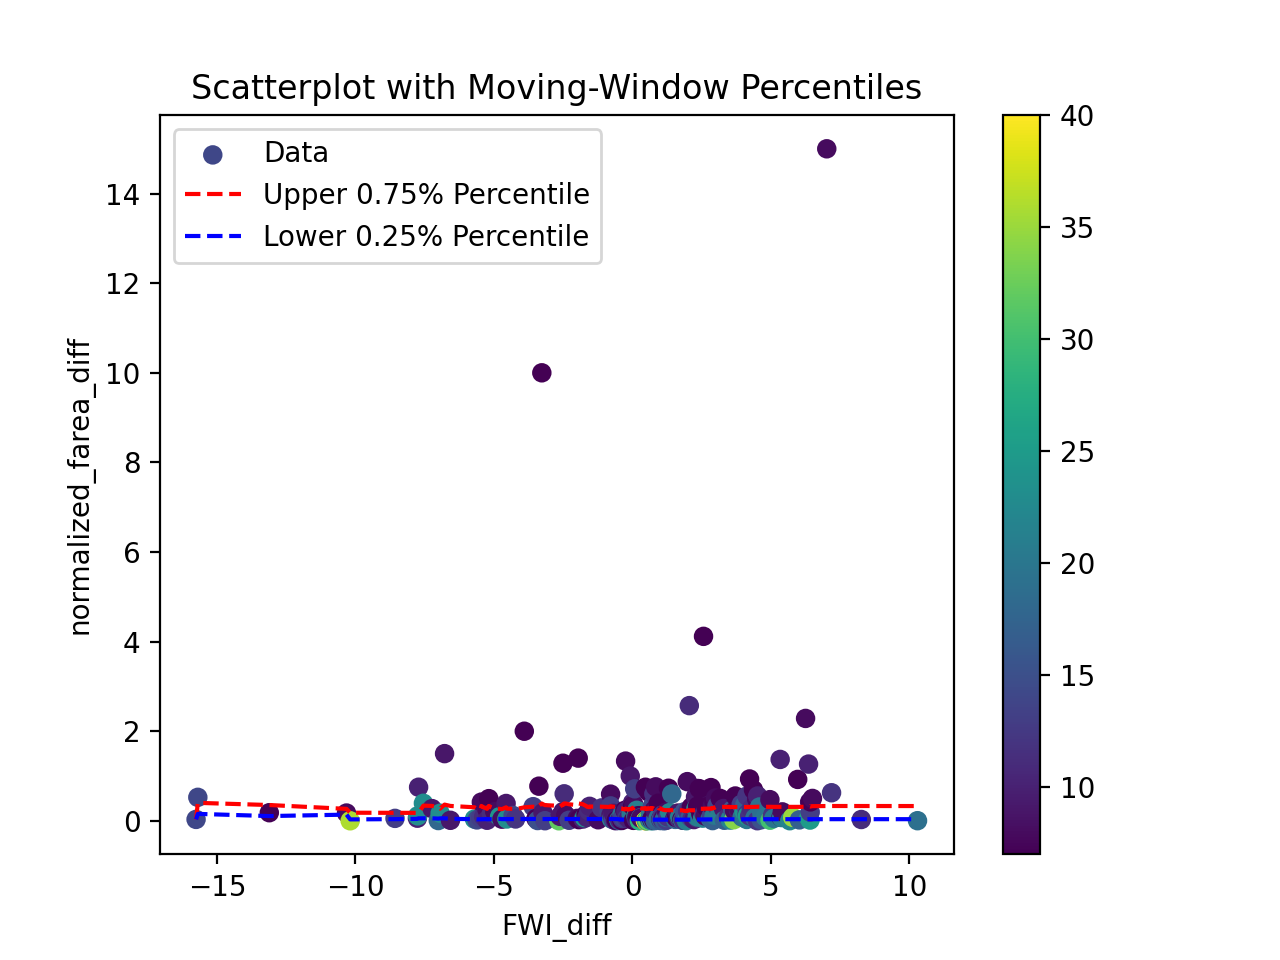

In [51]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) & (fire3.day_of_fire >=7) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI_diff"
y_col = "normalized_farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data', c = fire3[row_mask]["day_of_fire"])

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Scatterplot with Moving-Window Percentiles')
plt.legend()
plt.colorbar()
#plt.yscale('log')
plt.show()

In [52]:
#### Maybe the realtionship is modified by the duration of the fire. Checking that now. By normalizing by day of fire??????

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

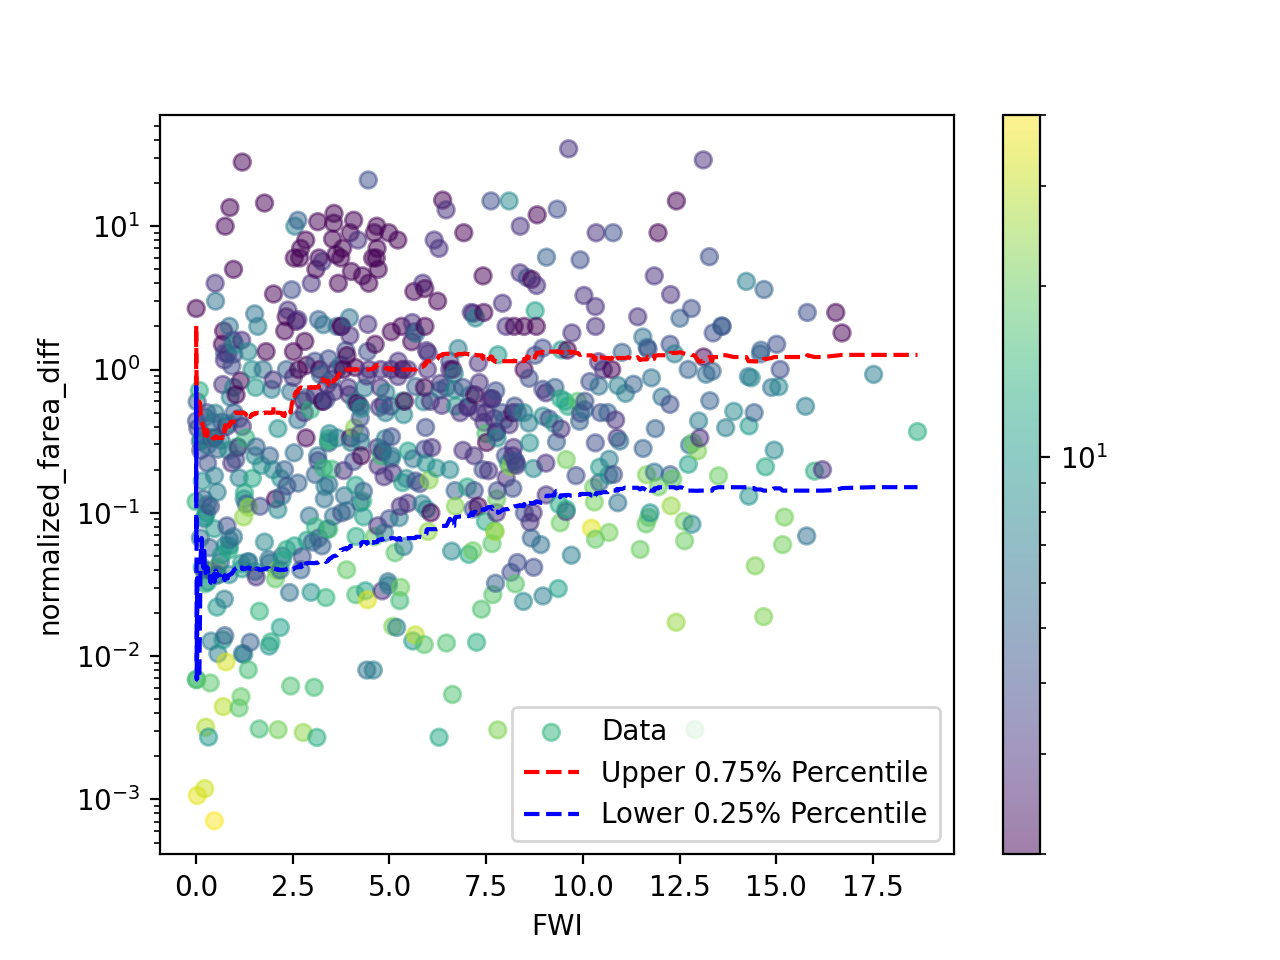

In [53]:
row_mask = (~fire3.fireID.str.contains("_")) & (fire3.farea_diff >= 0.1) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

conf_level = ["0.75", "0.25"]

fire3["normalized_farea_diff"] = fire3.farea_diff/fire3.farea_shifted

x_col = "FWI"
y_col = "normalized_farea_diff"
window_size = 10
fire3 = fire3.sort_values(by = [x_col])
#fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
#fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



# Plot scatter plot
plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data',  c = fire3[row_mask]["day_of_fire"], norm="log", alpha=0.5)

# Plot moving-window upper and lower percentiles
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('')
plt.legend()
plt.yscale('log')
plt.colorbar()
plt.show()

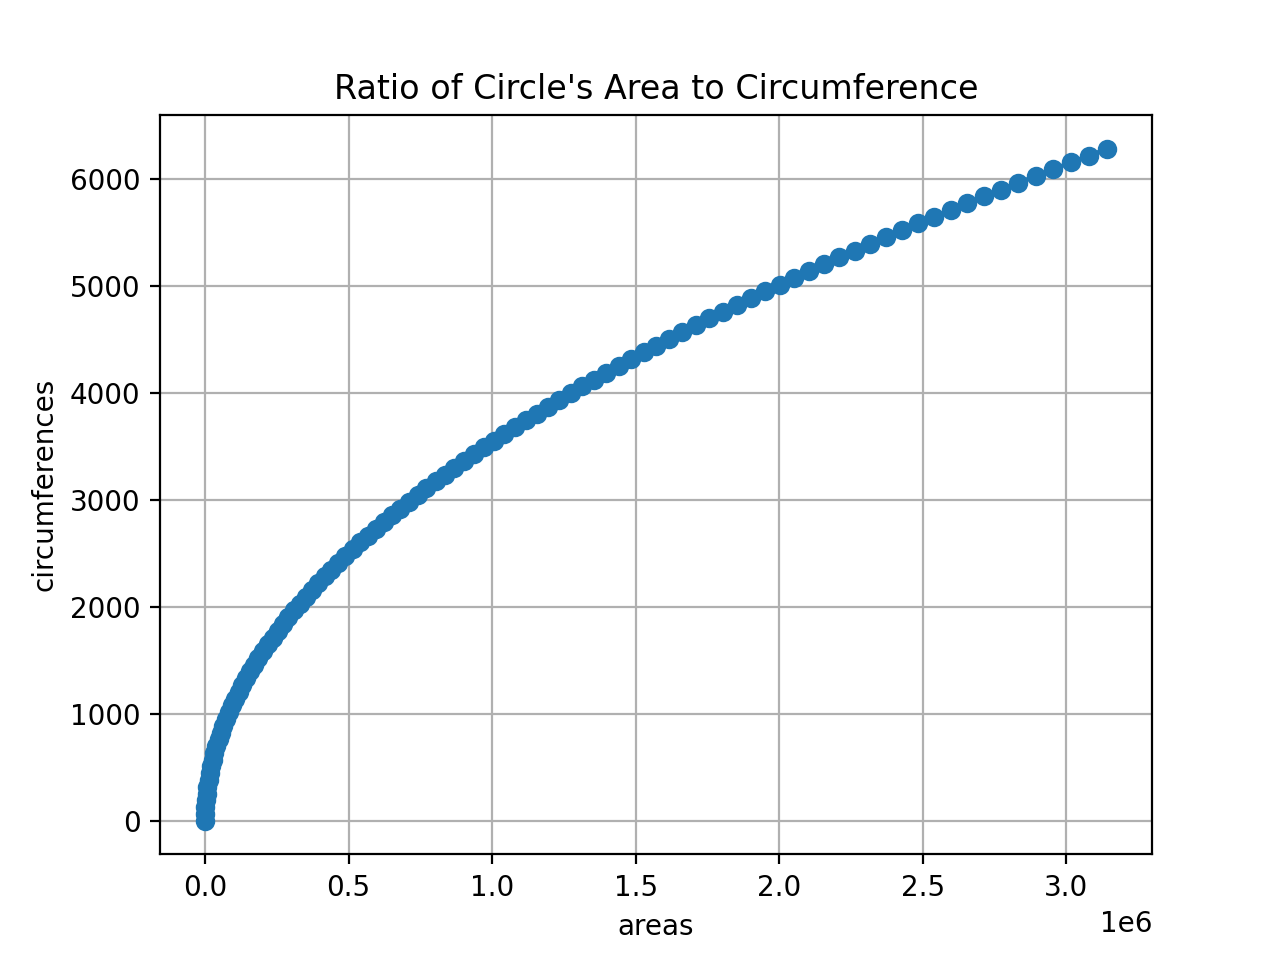

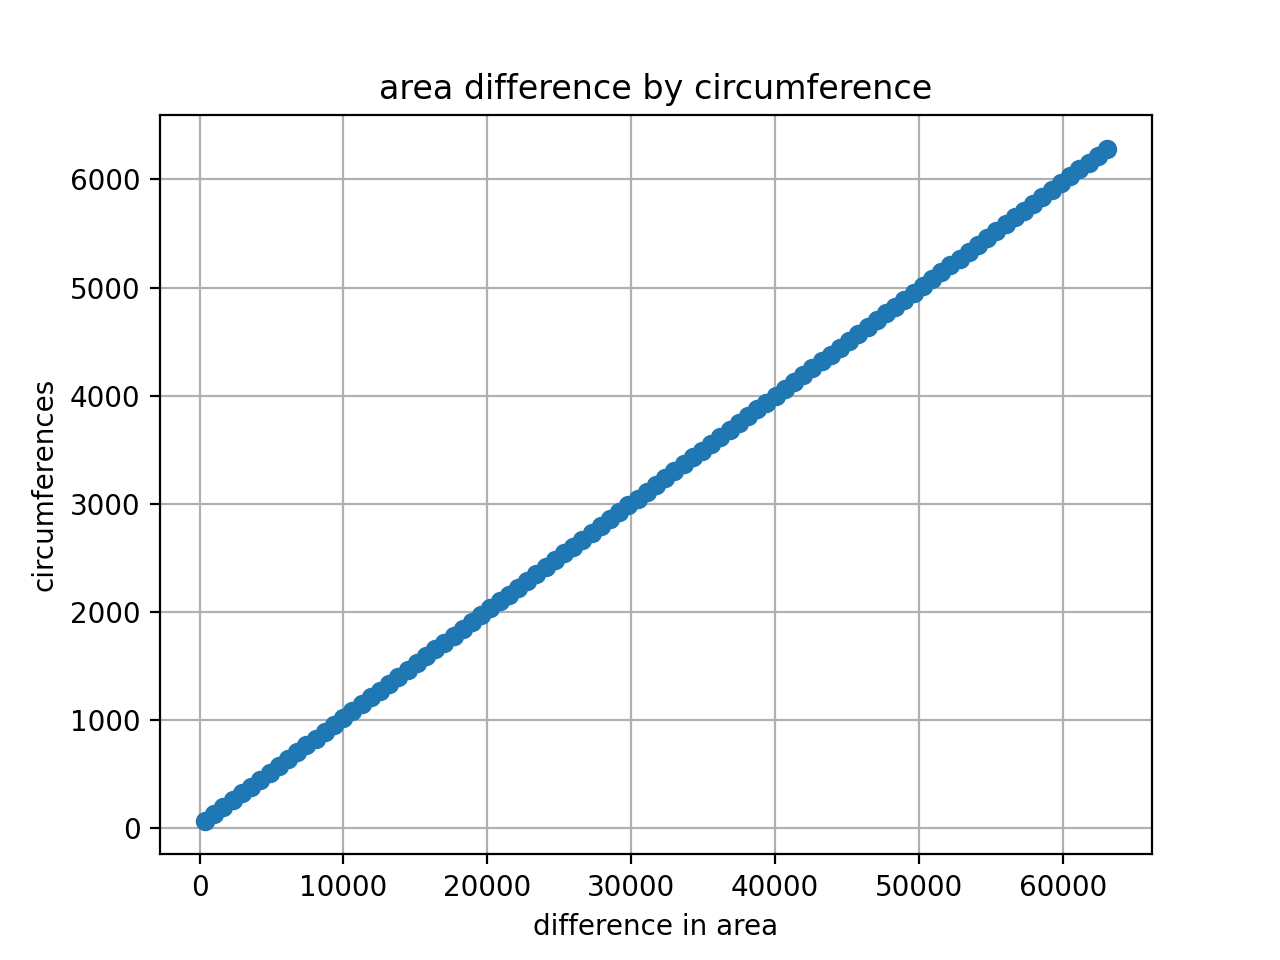

100 100


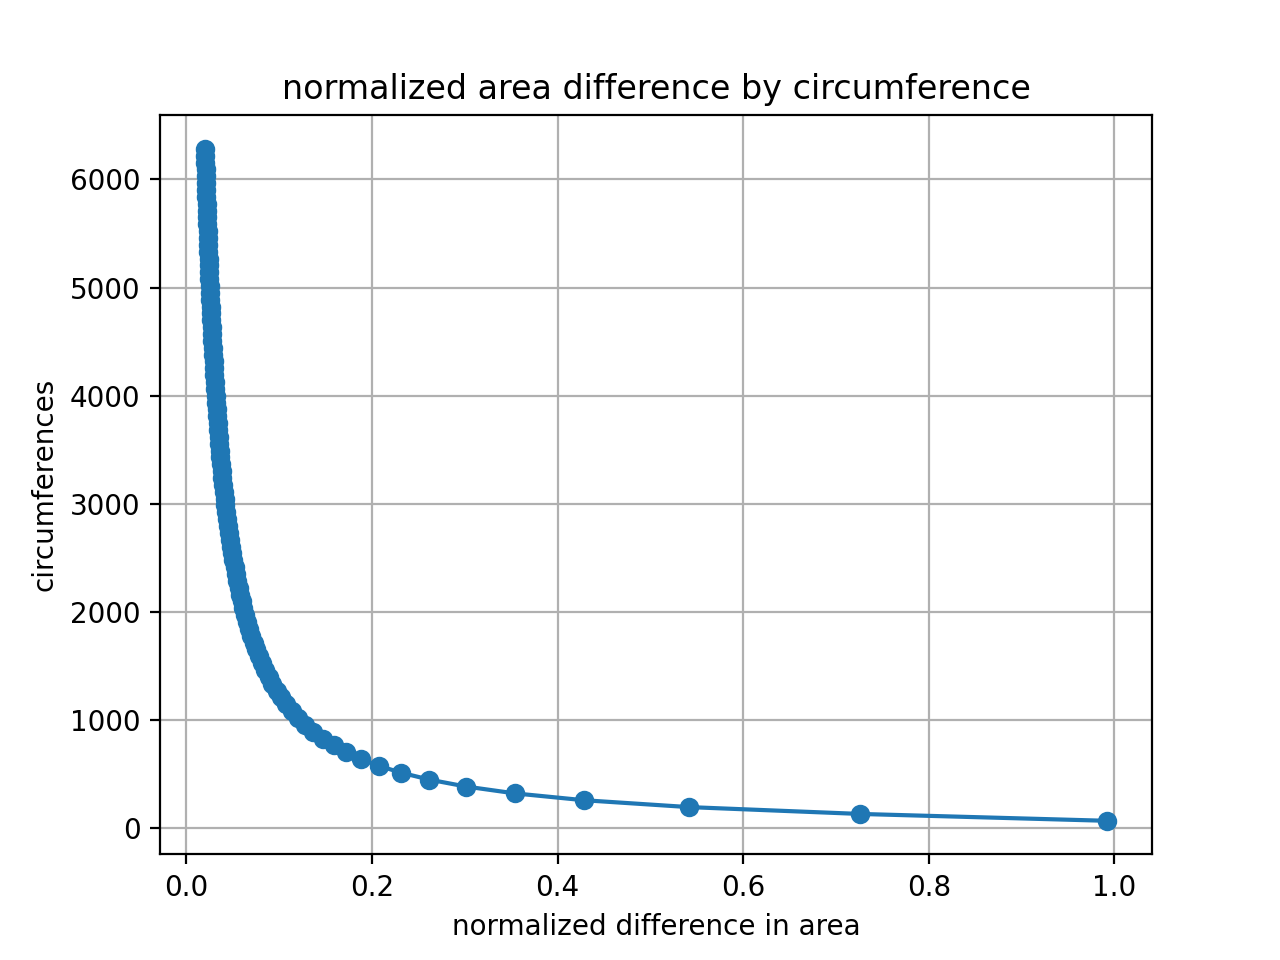

In [54]:
def calculate_area(radius):
    """
    Function to calculate the ratio of circle's area to circumference.
    """
    area = np.pi * (radius**2)
    
    return area 

def calculate_circumference(radius):
    circumference = 2 * np.pi * radius
    return circumference


def plot_ratio(radius_range):
    """
    Function to plot the ratio of circle's area to circumference as circle grows.
    """
    areas = [calculate_area(r) for r in radius_range]
    circumferences = [calculate_circumference(r) for r in radius_range]
    plt.plot(areas, circumferences, marker='o', linestyle='-')
    plt.xlabel('areas')
    plt.ylabel('circumferences')
    plt.title('Ratio of Circle\'s Area to Circumference')
    plt.grid(True)
    plt.show()
    

def area_differences_scaled_with_circumference(radius_range):
    areas = [calculate_area(r) for r in radius_range]
    circumferences = [calculate_circumference(r) for r in radius_range]
    
    areas_diff = [None, *np.diff(areas)]
    plt.plot(areas_diff, circumferences, marker='o', linestyle='-')
    plt.xlabel('difference in area')
    plt.ylabel('circumferences')
    plt.title('area difference by circumference')
    plt.grid(True)
    plt.show()

    
def area_differences_scaled_with_circumference(radius_range):
    areas = [calculate_area(r) for r in radius_range]
    circumferences = [calculate_circumference(r) for r in radius_range]
    
    areas_diff = [None, *np.diff(areas)]
    plt.plot(areas_diff, circumferences, marker='o', linestyle='-')
    plt.xlabel('difference in area')
    plt.ylabel('circumferences')
    plt.title('area difference by circumference')
    plt.grid(True)
    plt.show()
    

def norm_area_differences_scaled_with_circumference(radius_range):
    areas = [calculate_area(r) for r in radius_range]
    circumferences = [calculate_circumference(r) for r in radius_range]
    
    areas_diff = [None, *np.diff(areas)]
    print(len(areas_diff), len(areas))
    
    normalized_area_difference = result = [a / b for a, b in zip(areas_diff[1:], areas[1:])]
    plt.plot(normalized_area_difference, circumferences[1:], marker='o', linestyle='-')
    plt.xlabel('normalized difference in area')
    plt.ylabel('circumferences')
    plt.title('normalized area difference by circumference')
    plt.grid(True)
    plt.show()
    

def norm_area_differences_scaled_with_circumference(radius_range):
    areas = [calculate_area(r) for r in radius_range]
    circumferences = [calculate_circumference(r) for r in radius_range]
    
    areas_diff = [None, *np.diff(areas)]
    print(len(areas_diff), len(areas))
    
    normalized_area_difference = result = [a / b for a, b in zip(areas_diff[1:], areas[1:])]
    
    
    plt.plot(normalized_area_difference, circumferences[1:], marker='o', linestyle='-')
    plt.xlabel('normalized difference in area')
    plt.ylabel('circumferences')
    plt.title('normalized area difference by circumference')
    plt.grid(True)
    plt.show()



radius_range = np.linspace(1, 1000, 100)
plot_ratio(radius_range)
area_differences_scaled_with_circumference(radius_range)
norm_area_differences_scaled_with_circumference(radius_range)

In [55]:
fire3.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 1', 'fireID.1', 'csv_geometry',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1',
       'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6',
       'FWI_lead_7', 'FWI_lead_8', 'farea_diff', 'farea_diff_minus1',
       'farea_shifted', 'FWI_diff', 'FWI_shifted', 'bin', 'FWI_norm',
       'FWI_diff_norm', 'max_fwi', 'max_farea_diff', 'FWI_max',
       'normalized_farea_diff', 'farea0.75', 'farea0.25',
       'normalized_farea_diff0.75', 'normalized_farea_diff0.25',
       'farea_diff0.75', 'farea_diff0.25', 'day_of_fire'],
      dtype='object')

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


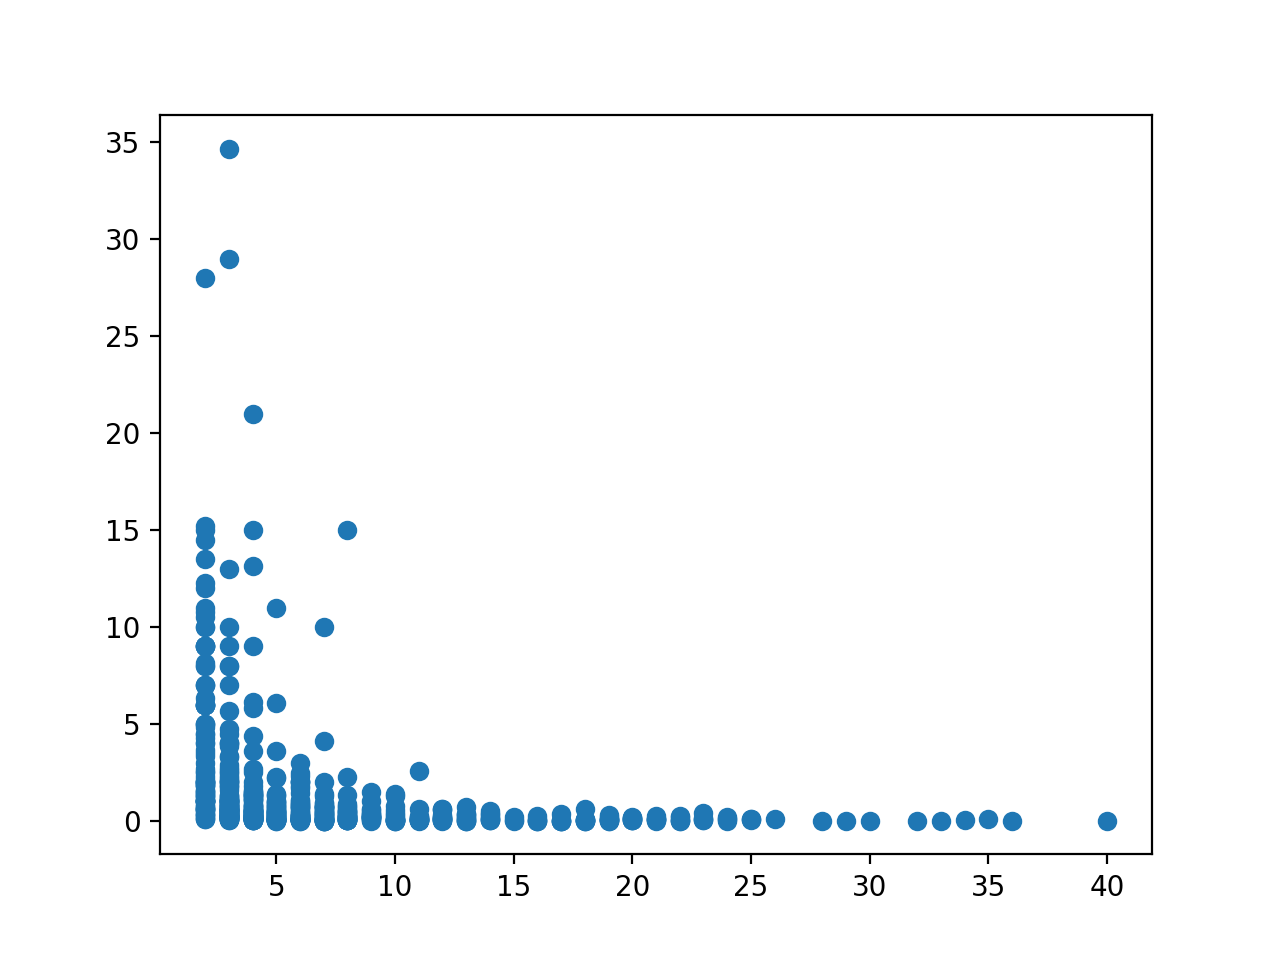

In [56]:
plt.scatter(fire3[row_mask].day_of_fire, fire3[row_mask].normalized_farea_diff)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


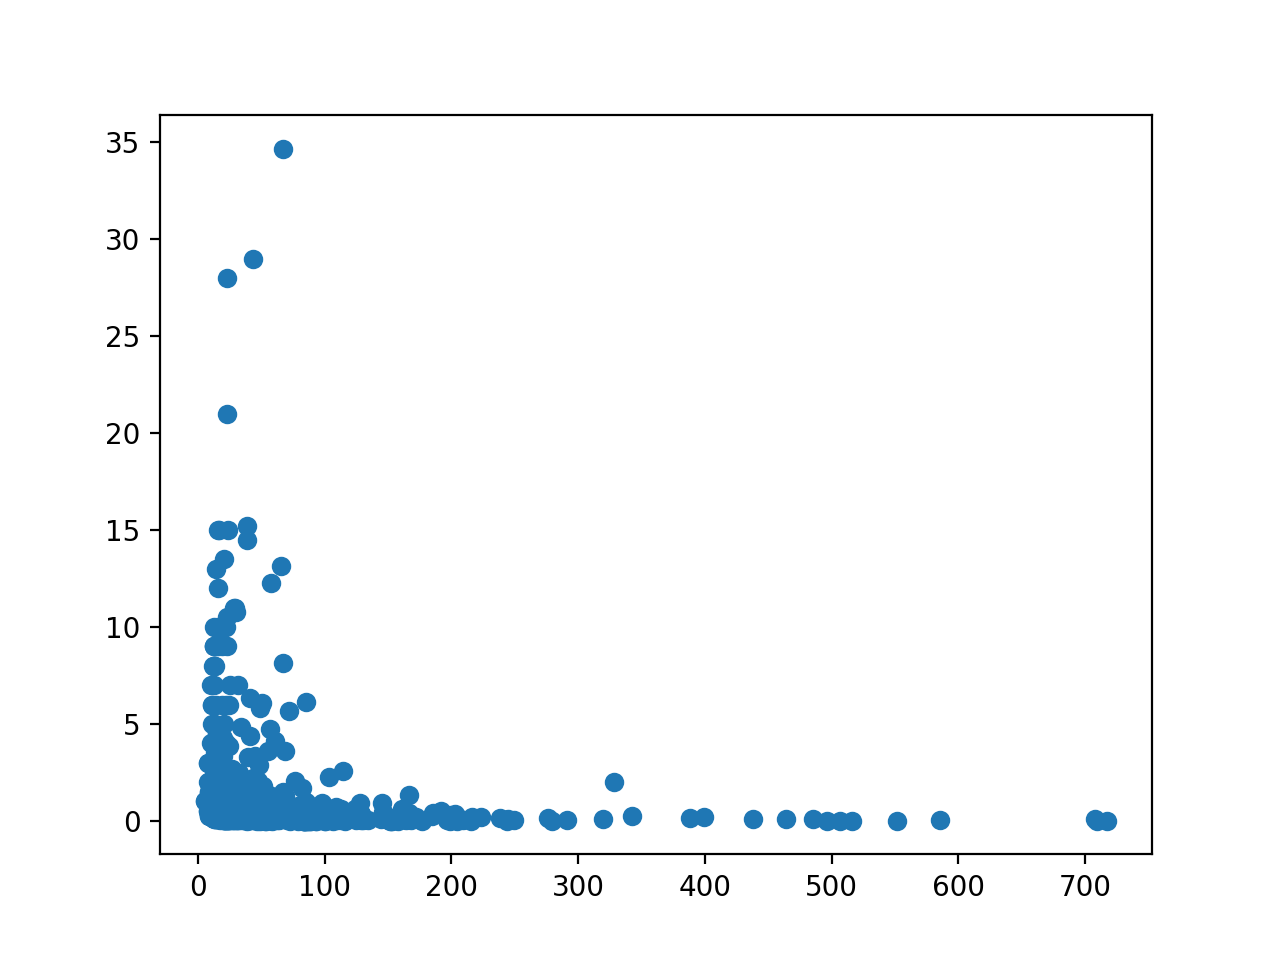

In [57]:
plt.scatter(fire3[row_mask].fperim, fire3[row_mask].normalized_farea_diff)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


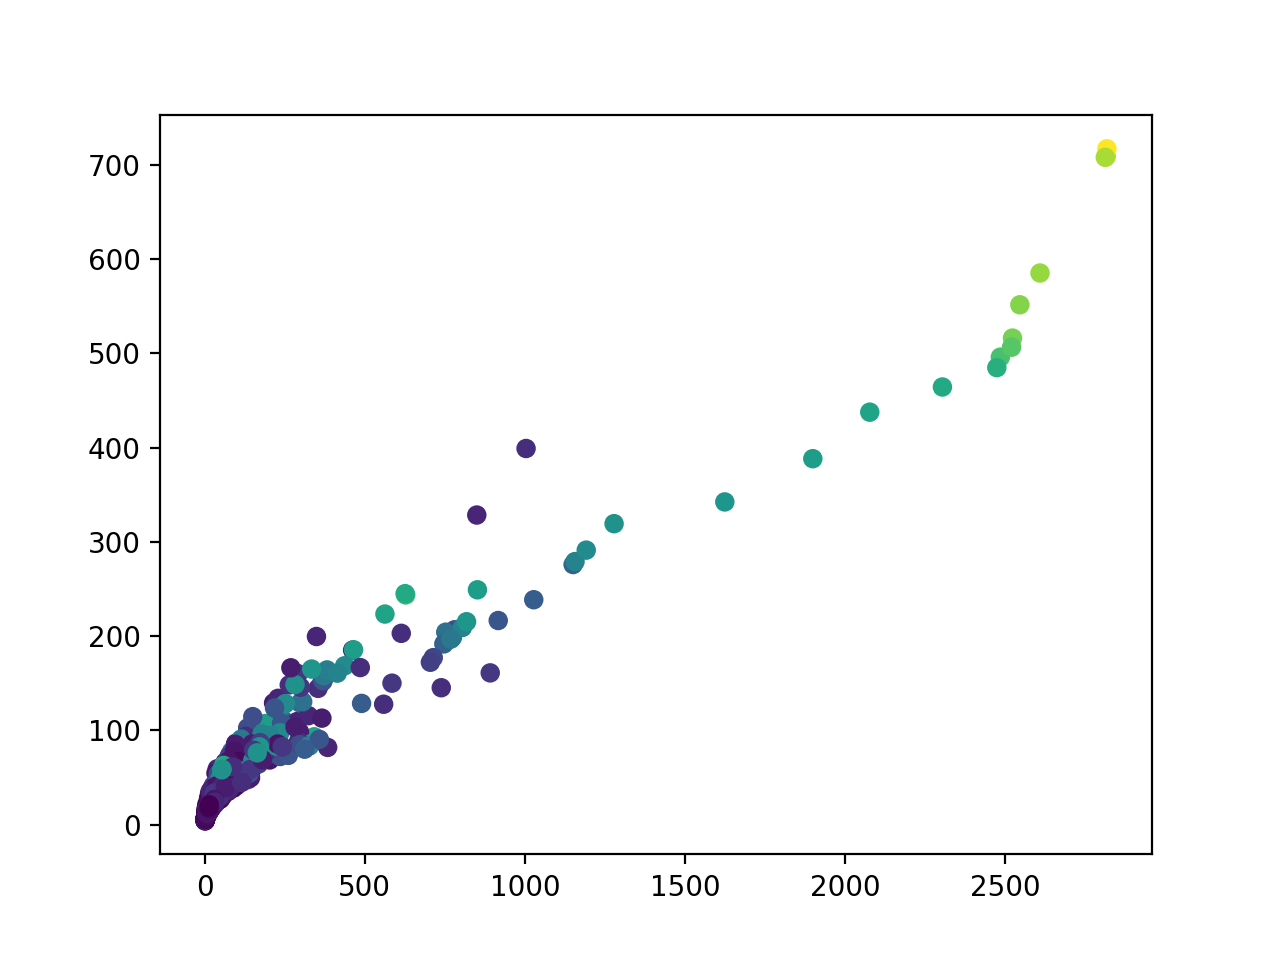

In [58]:
plt.scatter(fire3[row_mask].farea, fire3[row_mask].fperim, c = fire3[row_mask].day_of_fire)

In [59]:
len(fire3[row_mask].fireID.unique())

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


179

In [60]:
fire3.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 1', 'fireID.1', 'csv_geometry',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1',
       'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6',
       'FWI_lead_7', 'FWI_lead_8', 'farea_diff', 'farea_diff_minus1',
       'farea_shifted', 'FWI_diff', 'FWI_shifted', 'bin', 'FWI_norm',
       'FWI_diff_norm', 'max_fwi', 'max_farea_diff', 'FWI_max',
       'normalized_farea_diff', 'farea0.75', 'farea0.25',
       'normalized_farea_diff0.75', 'normalized_farea_diff0.25',
       'farea_diff0.75', 'farea_diff0.25', 'day_of_fire'],
      dtype='object')

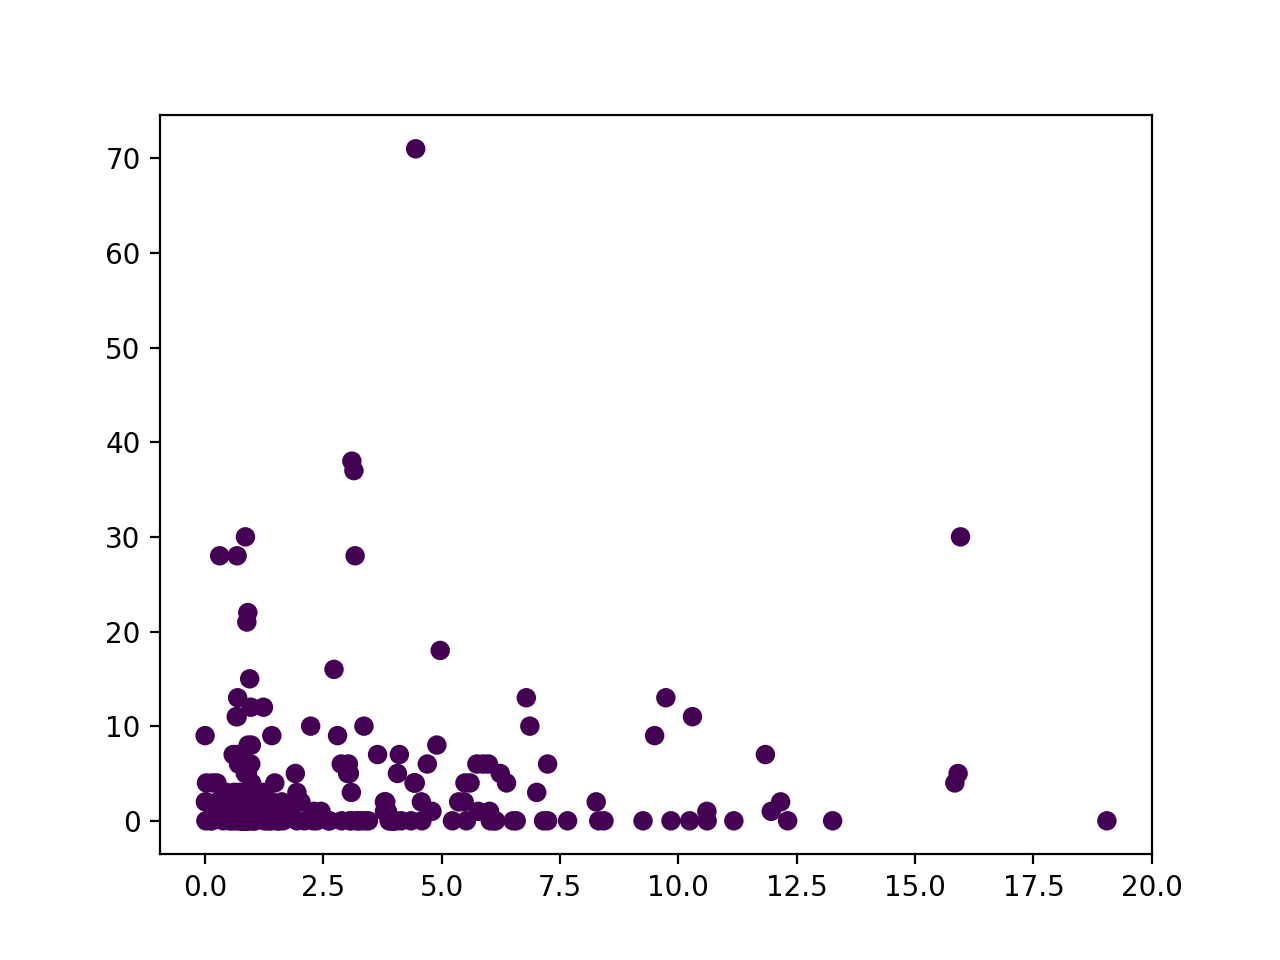

In [61]:
### Check the FWI just at ignition
row_mask = (fire3.day_of_fire == 1) & (~fire3.fireID.str.contains("_"))
plt.scatter(fire3[row_mask].FWI,fire3[row_mask].farea, c = fire3[row_mask].day_of_fire)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

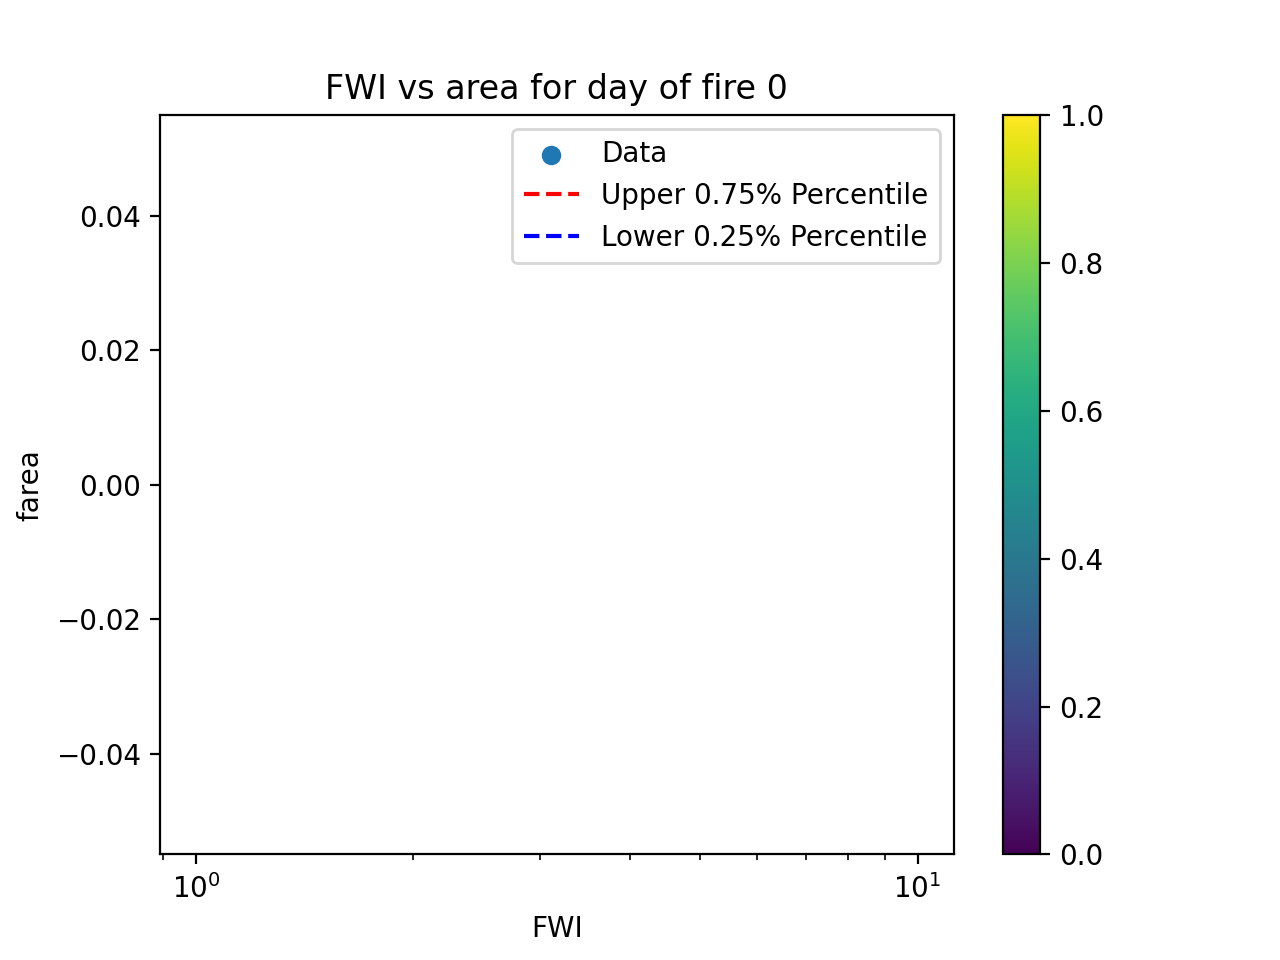

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

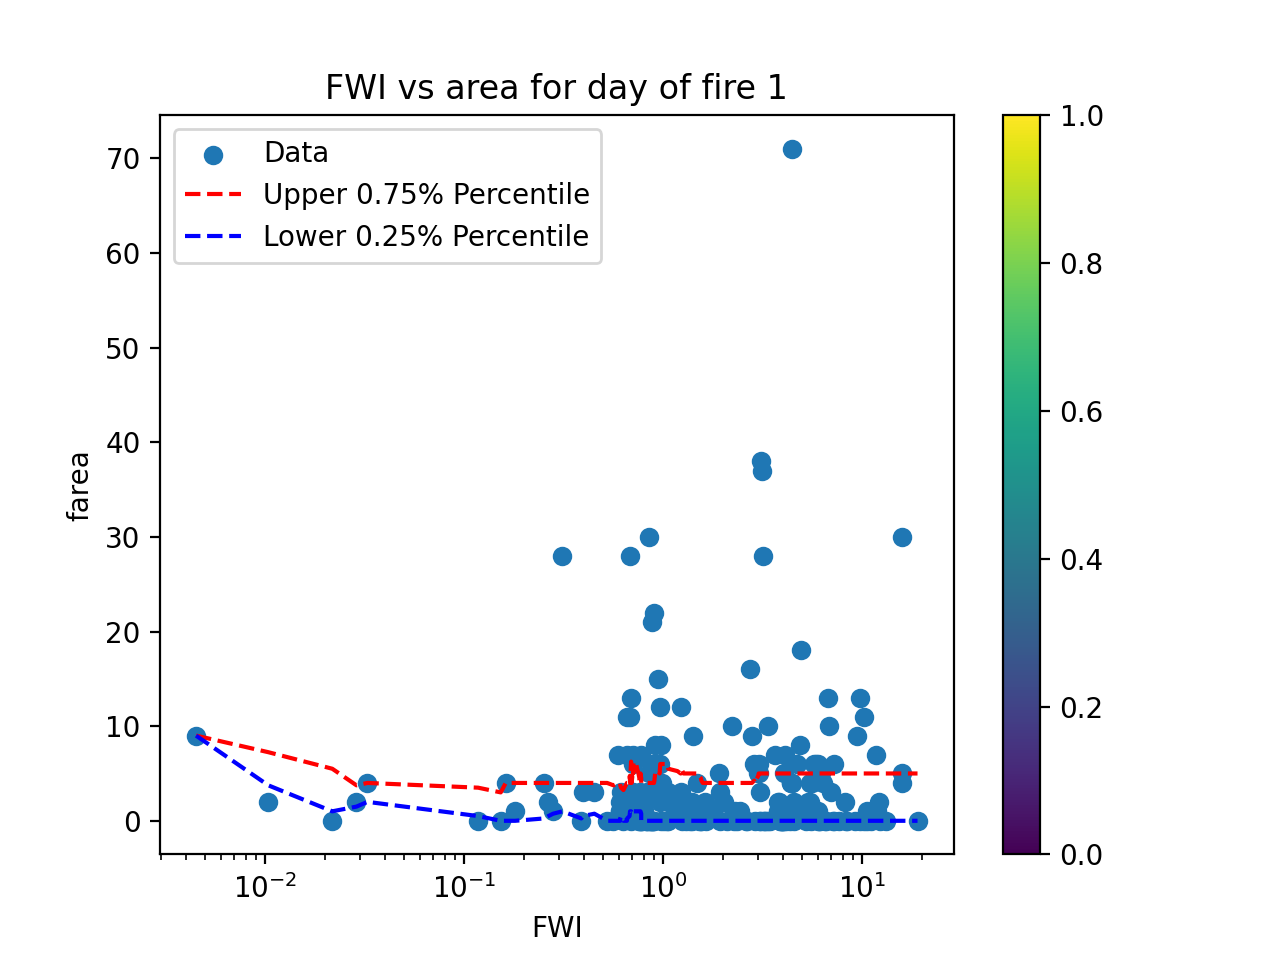

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

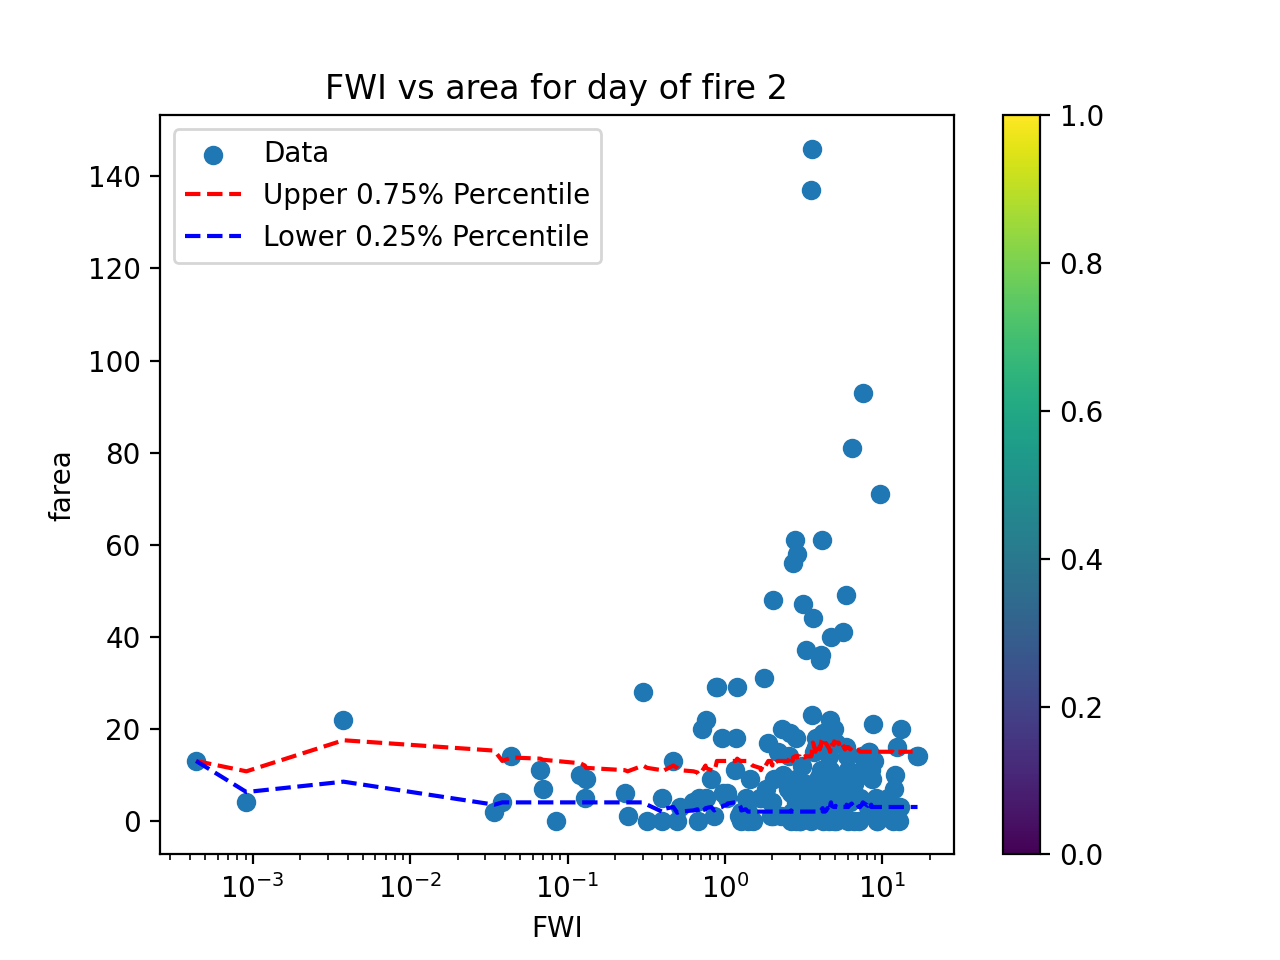

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

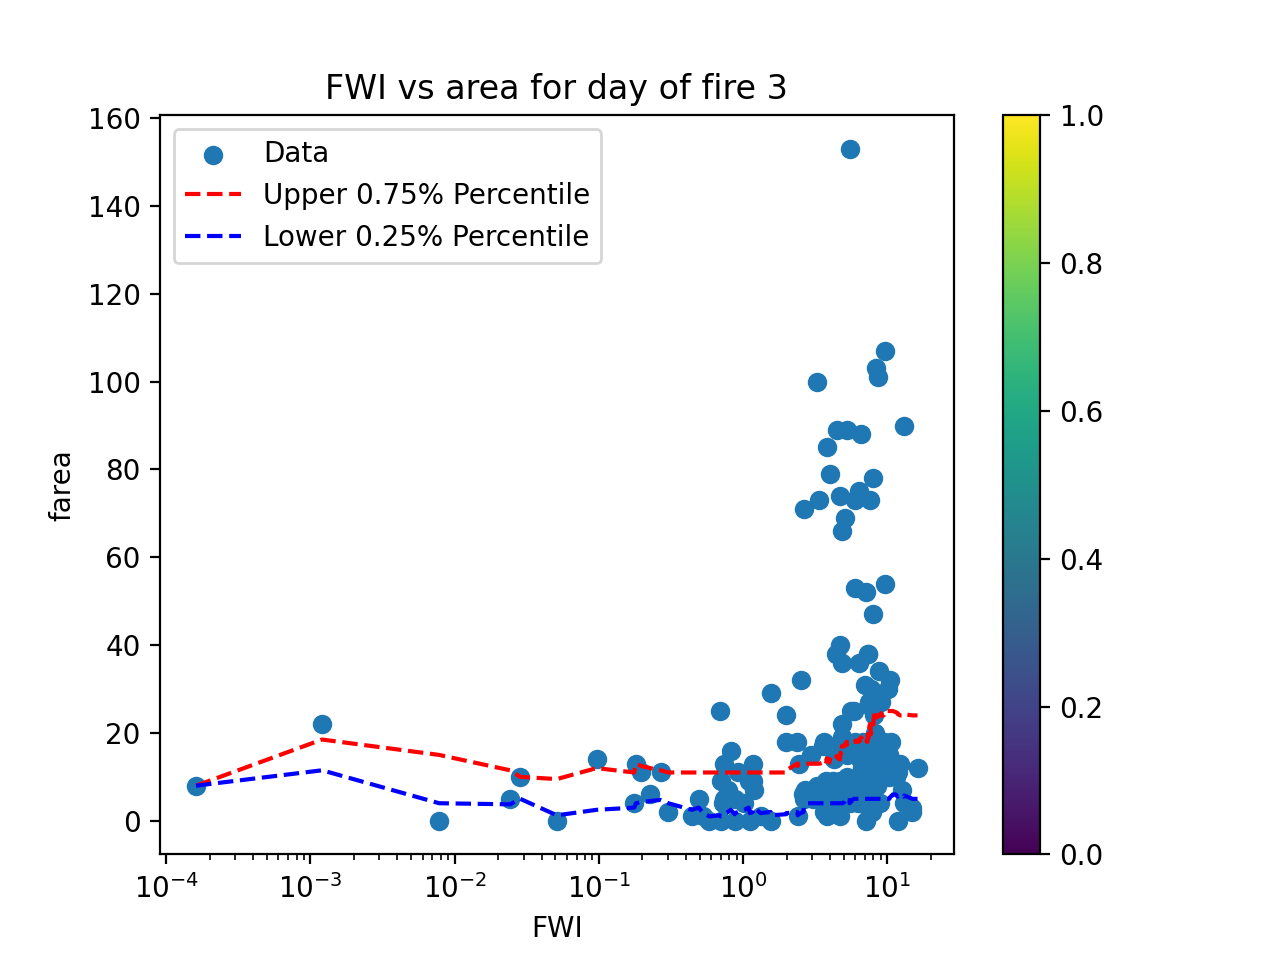

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

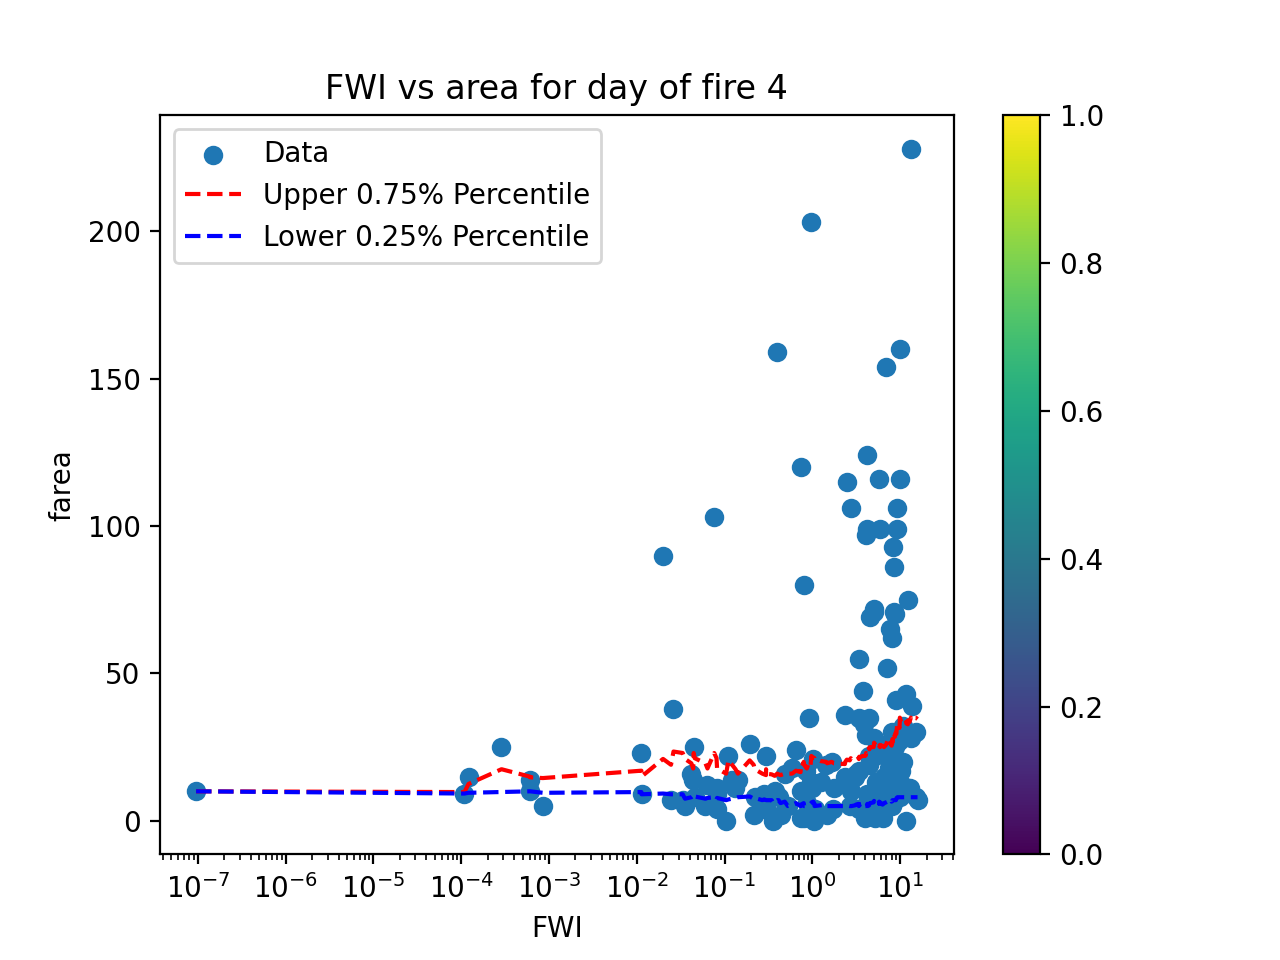

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

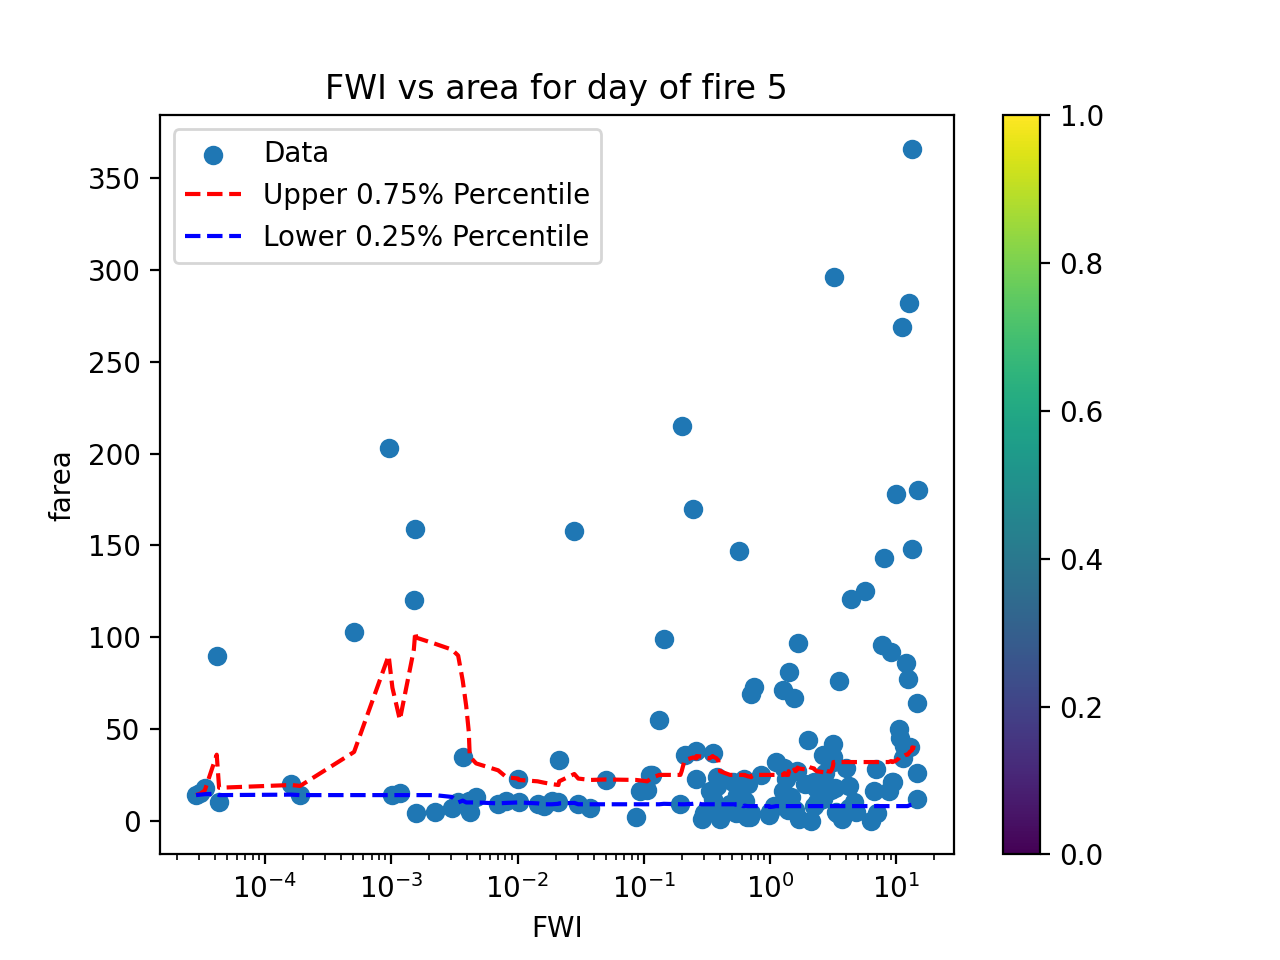

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

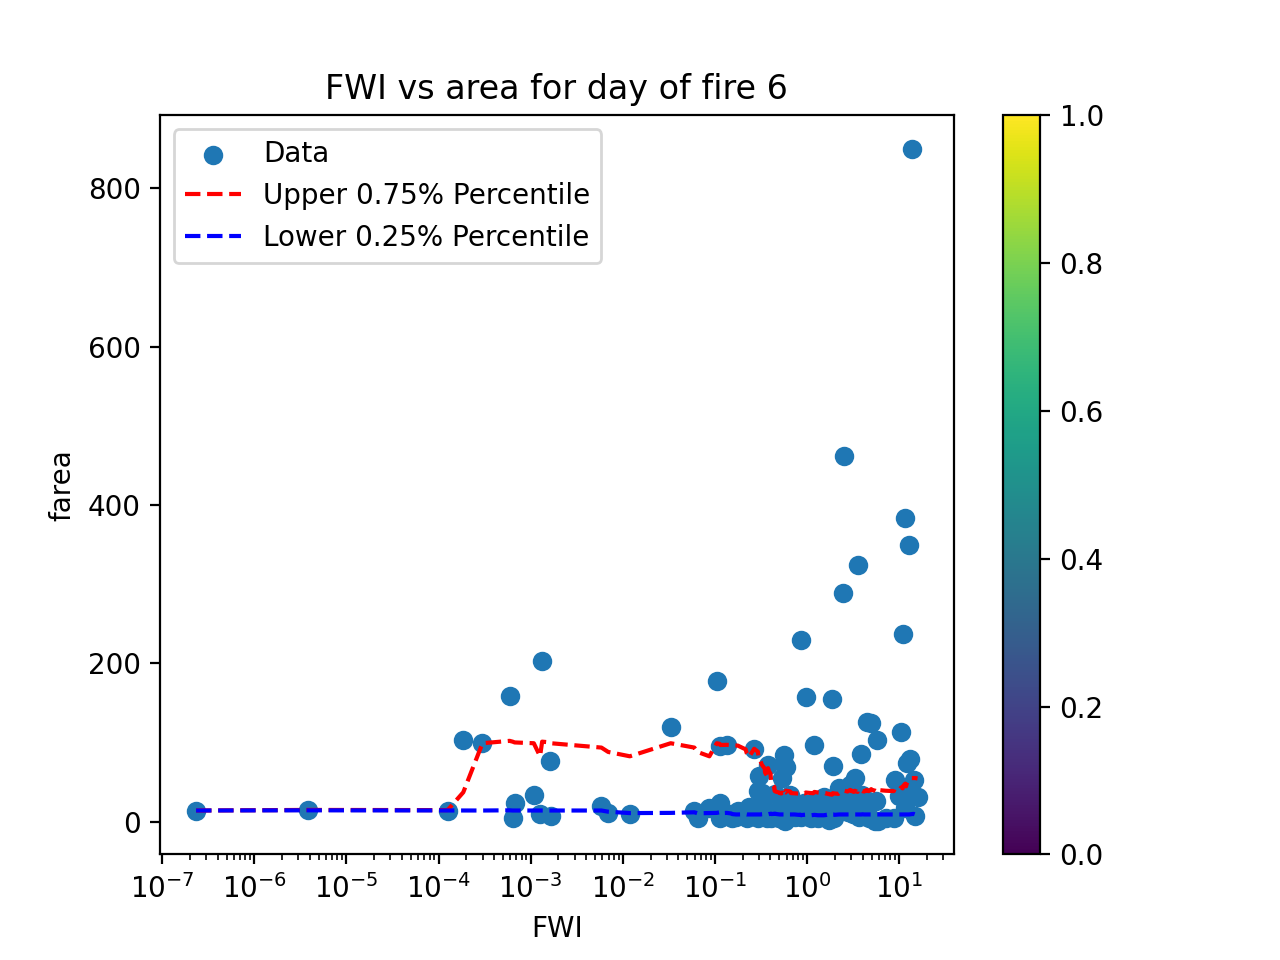

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

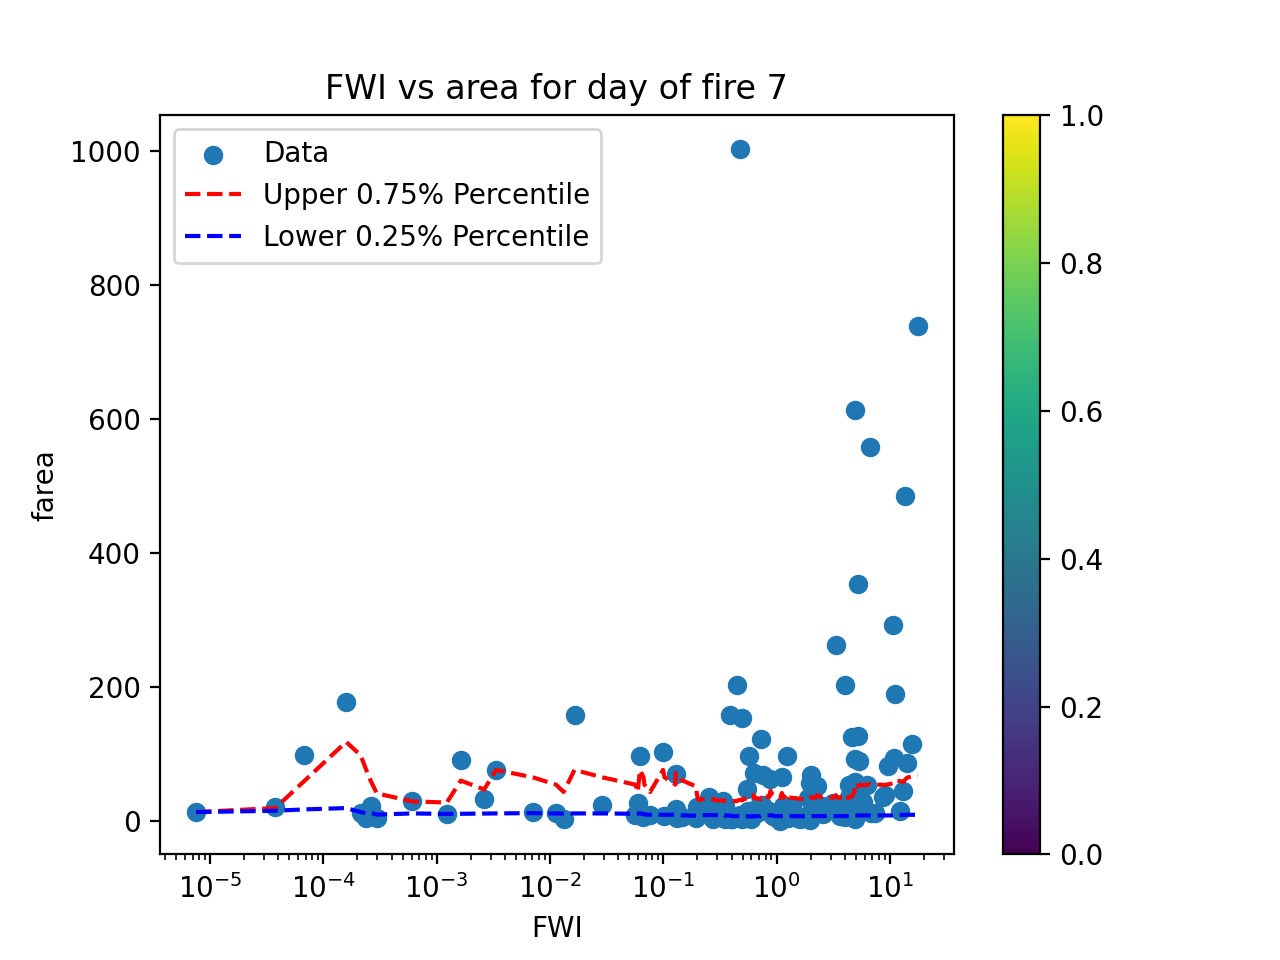

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

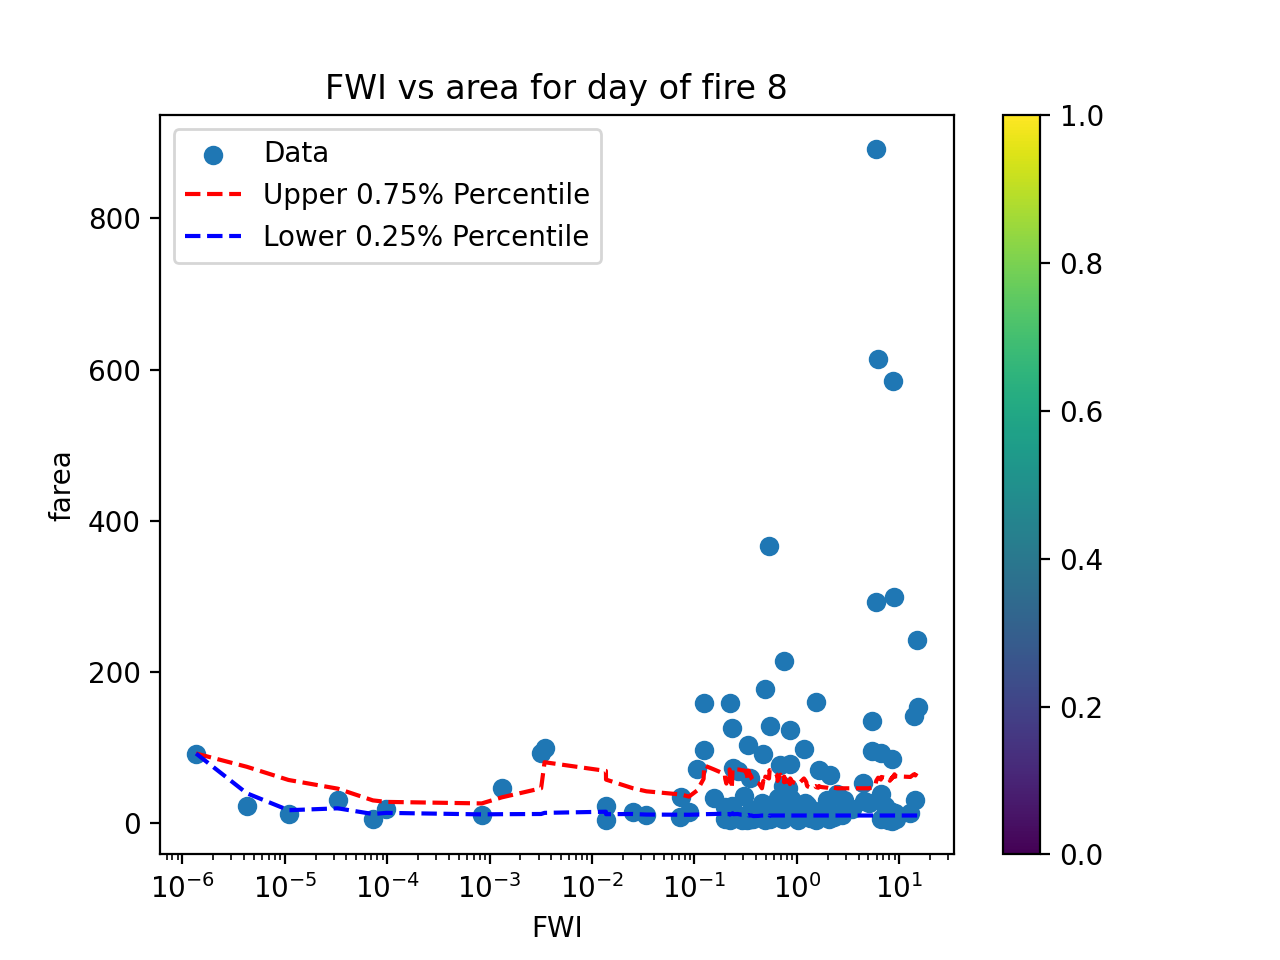

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match Dat

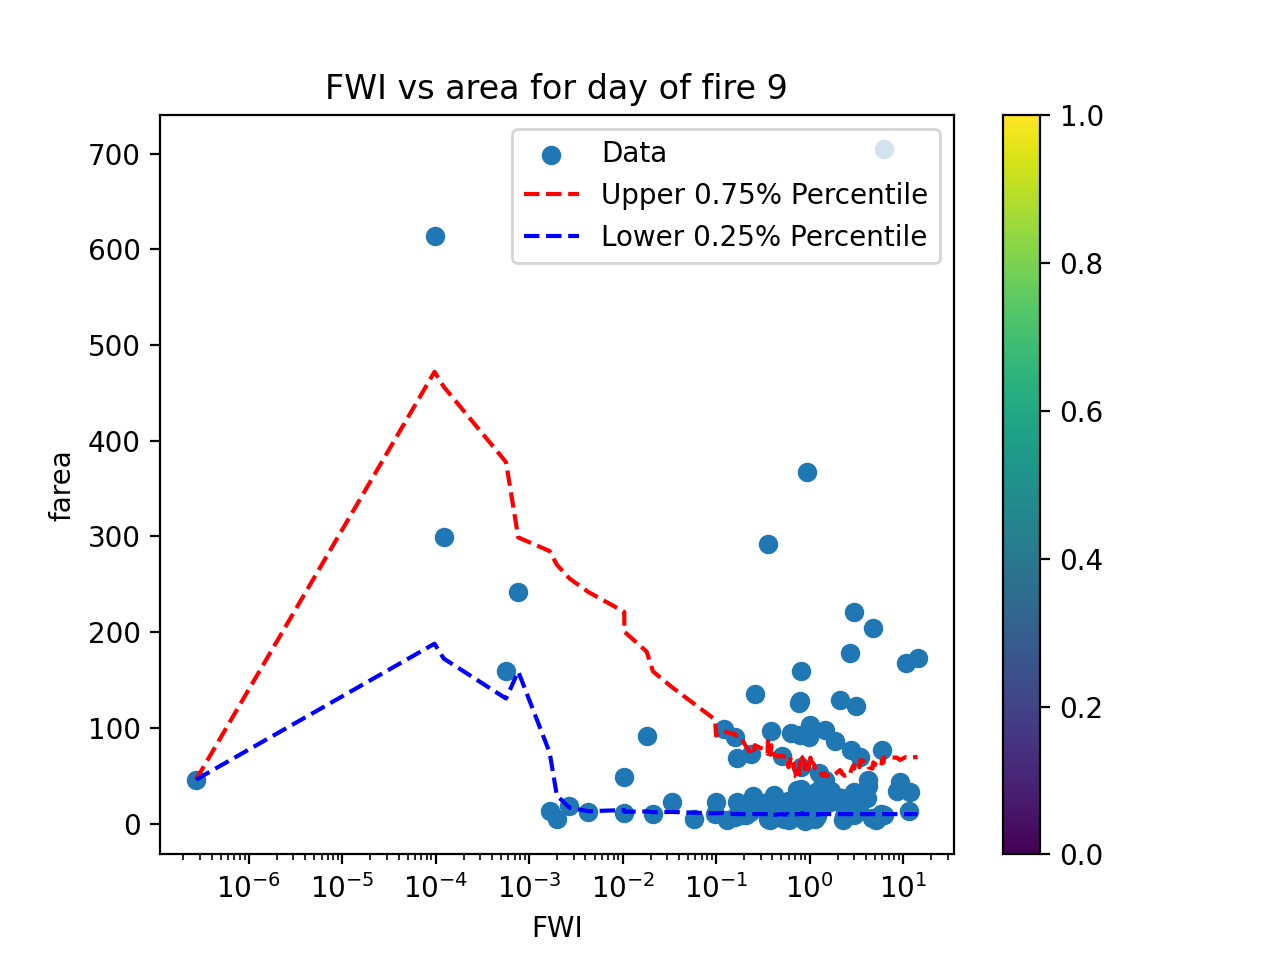

In [62]:
for i in range(0, 10):
    row_mask = (fire3.day_of_fire == i) & (~fire3.fireID.str.contains("_")) #fire3.fireID.isin(fire3.fireID)#(~fire3.fireID.str.contains("_")) & (fire3.farea_diff > 0.1)

    conf_level = ["0.75", "0.25"]

    x_col = "FWI"
    y_col = "farea"
    window_size = 10
    fire3 = fire3.sort_values(by = [x_col])
    #fire3[ y_col + conf_level[0] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[0]))).reset_index(drop = True)#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
    #fire3[ y_col + conf_level[1] ] = fire3.groupby("fireID")[y_col].transform(lambda d: d.rolling(40, min_periods=1).quantile(float(conf_level[1]))).reset_index(drop = True)

    fire3[ y_col + conf_level[0] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[0]))#.transform.rolling(window=window_size).quantile(float(conf_level[0]))
    fire3[ y_col + conf_level[1] ] = fire3.loc[row_mask, [y_col]].rolling(400, min_periods=1).quantile(float(conf_level[1]))



    # Plot scatter plot
    plt.scatter(fire3[row_mask][x_col], fire3[row_mask][y_col], label='Data')

    # Plot moving-window upper and lower percentiles
    plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[0] ], color='red', linestyle='--', label='Upper '+ conf_level[0]+ '% Percentile')
    plt.plot(fire3[row_mask][x_col], fire3[row_mask][ y_col + conf_level[1] ], color='blue', linestyle='--', label='Lower '+  conf_level[1] +'% Percentile')

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'FWI vs area for day of fire {i}')
    plt.legend()
    plt.colorbar()
    #plt.yscale('log')
    plt.xscale('log')
    plt.show()

In [63]:
fire3.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 1', 'fireID.1', 'csv_geometry',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1',
       'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6',
       'FWI_lead_7', 'FWI_lead_8', 'farea_diff', 'farea_diff_minus1',
       'farea_shifted', 'FWI_diff', 'FWI_shifted', 'bin', 'FWI_norm',
       'FWI_diff_norm', 'max_fwi', 'max_farea_diff', 'FWI_max',
       'normalized_farea_diff', 'farea0.75', 'farea0.25',
       'normalized_farea_diff0.75', 'normalized_farea_diff0.25',
       'farea_diff0.75', 'farea_diff0.25', 'day_of_fire'],
      dtype='object')

In [64]:
# row_mask = (fire3.day_of_fire == 4) & (~fire3.fireID.str.contains("_"))

# (ggplot(fire3[row_mask], aes("FWI", fire3[row_mask].farea))
#  + geom_jitter()
#  + plotnine.labels.ylab("Fire Area")
#  + plotnine.labels.xlab("FWI")
#  + stat_smooth(method = "glm")
#  + plotnine.scale_x_log10()
    
# )

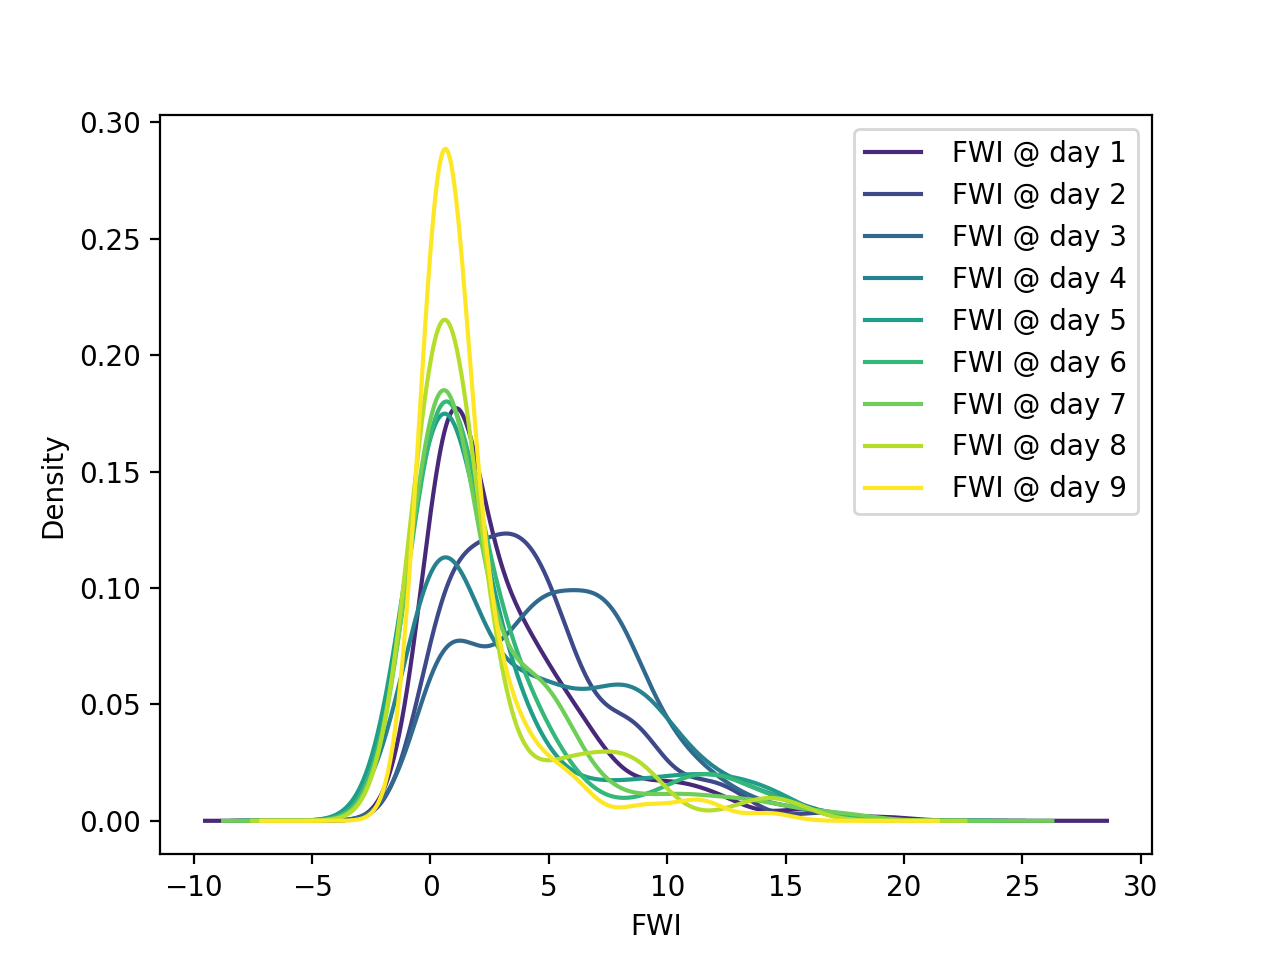

In [65]:
colors = plt.cm.viridis(np.linspace(0,1,10))
#fire3.FWI.plot(kind='density', color = "black", label = "overall FWI")
for i in range(1, 10):
    row_mask = (fire3.day_of_fire == i) & (~fire3.fireID.str.contains("_"))
    
    fire3[row_mask].FWI.plot(kind = "density", label = f" FWI @ day {i}", color = colors[i])
plt.legend()
plt.xlabel("FWI")

plt.show()

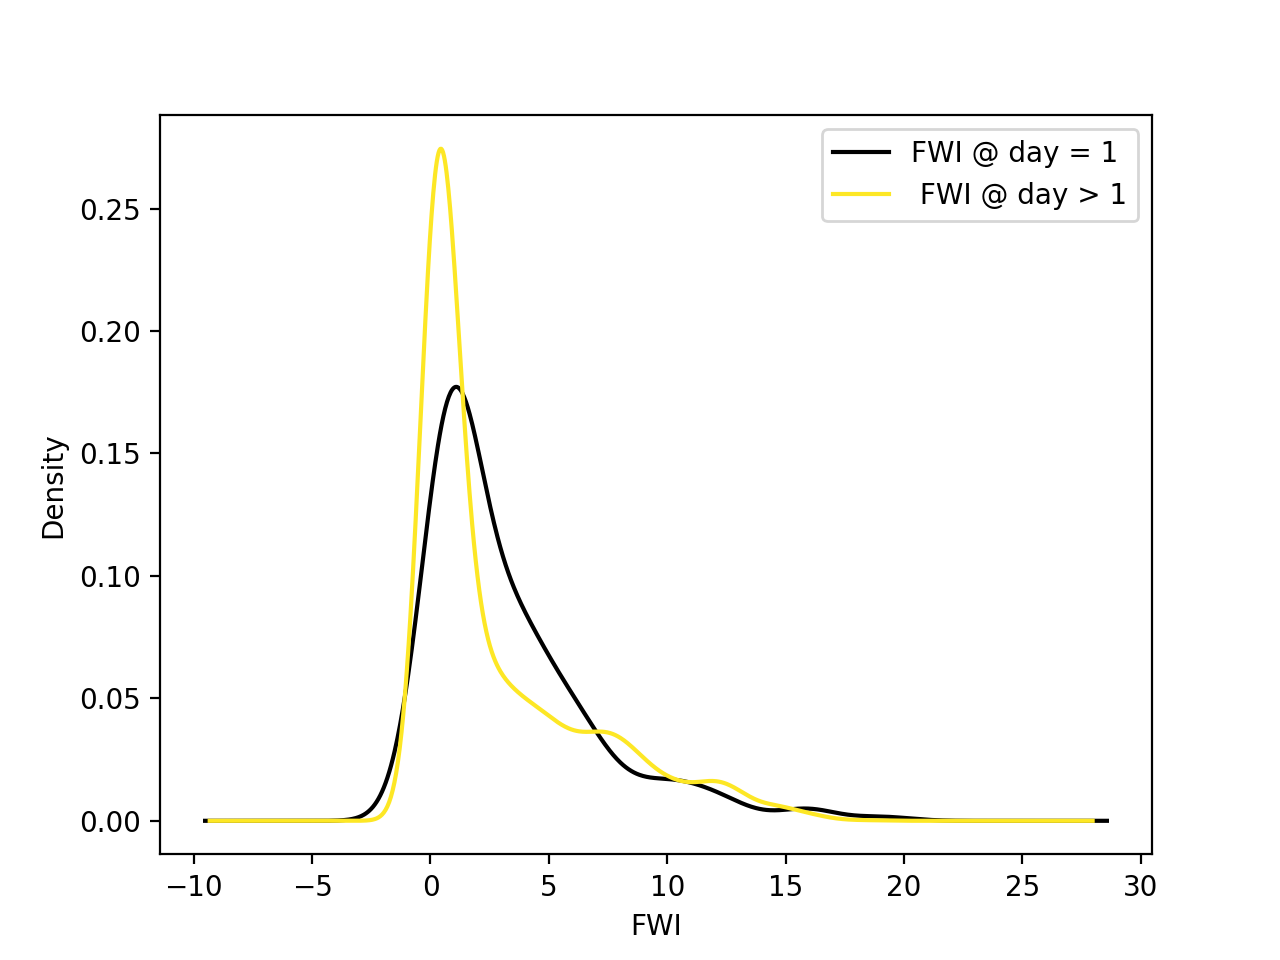

In [66]:
colors = plt.cm.viridis(np.linspace(0,1,10))

row_mask = (fire3.day_of_fire == 1) & (~fire3.fireID.str.contains("_"))

fire3[row_mask].FWI.plot(kind='density', color = "black", label = "FWI @ day = 1")

row_mask = (fire3.day_of_fire > 1) & (~fire3.fireID.str.contains("_"))
    
fire3[row_mask].FWI.plot(kind = "density", label = f" FWI @ day > 1", color = colors[i])
plt.legend()
plt.xlabel("FWI")

plt.show()

In [67]:
### Check out wierd problem fires
#import geoviews
#import hvplot.pandas

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
